# What I think needs to be refactored

- Each of the code under the for statements in the DistNodeNoParent can be its own function
  - Logic within each of the if statement could also be refactored into separate functions, for example, the logic for getting the distribution for discrete variables can be in a separate function, same for logic for getting distribution for any continuous variables.
  - The fitting function from fitter should be adjusted to avoid the excessive printing. Any way for using tqdm here?

- The for loop within SimNodeNoParent should be a separate function

- The SimulateAvailability Function should only produce an availability matrix, rather than concatenate it to the existing long format dataframe

- Each of the if statements within FitAlternativeRegression should be it's own separate function for fitting logistic regression vs. linear...

- We should write functions that take in a format of regression and produces the needed data. (for all regression equations)

- The for loop that simulates data N times and estimates any models should be written as a helper function.

- Helper function to plot the distribution of causal effects

- Helper function to recompute the regressions after the perturbations of variables.

- All the conditions are also to be written as separate methods.

- We have plenty of parameters that repeat themselves in multiple methods. I think it would be beneficial to create a parameter object that would store all these parameters and allow us to call methods using only one parameter. This will be helpful (in my opinion) while experimenting with different model specifications for example; We would not have to create numerous variables each time for each of the models. Instead, we will create an object (it should be a class in my opinion) from a collection of parameters, then just insert that class in all of our methods for that specific model. The parameters will be attributes of the class.

# Importing packages 

In [1]:
import sys
sys.path.append('../../src/')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import statsmodels.api as sm
import copy
from scipy import sparse
import scipy.stats
import random
from fitter import Fitter
import attr
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
from collections import defaultdict, OrderedDict
import pylogit as pl
import viz
from array import array

# 0. Functions for Documentation Purposes 

## 0.1. Distribution Fitting Class Definition - **Could be removed** - For Documentation Purposes

In [3]:
# class FitDistribution(object):
#     """Fit and simulate data to known distributions.

#     Input:
#     ------
#     - data: array-like or dataframe.
#     - dists: list.
#         This parameter contains a list of distributions to be explored.
#         When None, every available distribution on scipy is explored.
#     - bins: int.
#         Numbers of bins to be used for the cumulative histogram. This has
#         an impact on the quality of the fit.
#     - timeout: int.
#         Maximum time for a given distribution. If timeout is reached,
#         the distribution is skipped.
#         """
#     def __init__(self, data, dists=None, timeout=30, verbose=False, bins=100):
#         self.data = data
#         # self.var_types = var_types
#         self.dists = dists
#         self.timeout = timeout
#         self.verbose = verbose
#         self.bins = bins
#         self.ArrayDistDict = defaultdict()
#         self.params_dict = defaultdict(dict)

#     def FindArrayDist(self, cat_var):
#         """Function to extract the best distribution for a specified array.
#         Uses the fit method from the Fitter module in the fitter library
#         Inputs:
#         -------
#         - cat_var: boolean
#             Boolean to signify whether the variable to be simulated
#             is discrete/categorical or continuous.

#         Outputs:
#         -------
#         By default, the function returns a dictionary with best distribution
#         name and parameters associated with it. If a number of distributions
#         was specified, the function returns a pandas DataFrame with
#         the N best distributions, along with a plot showing all of them."""
#         self.ArrayDistDict = dict()
#         if cat_var is True:
#             self.ArrayDistDict['distribution'] = 'categorical'
#             np_array_range = np.arange(self.data.max()+1)
#             array_bincount = np.bincount(self.data)
#             probs = array_bincount / len(self.data)

#             self.ArrayDistDict['parameters'] = [np_array_range,
#                                                 probs]
#         else:
#             fitter_object = Fitter(data=self.data,
#                                    distributions=self.dists,
#                                    timeout=self.timeout)
#             fitter_object.fit()
#             BestDict = fitter_object.get_best()
#             self.ArrayDistDict['distribution'] = list(BestDict.items())[0][0]
#             self.ArrayDistDict['parameters'] = list(BestDict.items())[0][1]
#         return self.ArrayDistDict

#     def SimArray(self, size=100):
#         """Function to simulate data for an array based on the best fitted
#         distribution.
#         Input:
#         -----
#         - size : int
#                 size of the array to be simulated.
#         Outputs:
#         -------
#         Simulated array based on the best fit distribution."""
#         if self.ArrayDistDict['distribution'] == 'categorical':
#             value = self.ArrayDistDict['parameters'][0]
#             freq = self.ArrayDistDict['parameters'][1]
#             Sim_Array = np.random.choice(a=value,
#                                          p=freq,
#                                          size=size)
#         else:
#             dist = getattr(scipy.stats, self.ArrayDistDict['distribution'])
#             Sim_Array = dist.rvs(*self.ArrayDistDict['parameters'], size=size)
#         return Sim_Array

#     def FindDfDist(self, var_types):
#         """Function to extract the best distribution from a specified
#         dataframe. Uses the function find_dist, which in turn uses the
#         fit method from the Fitter module in the fitter library
#         Inputs:
#         -------
#         - var_types: dictionary
#             Dictionary with keys as column names for dataset variables,
#             the value of each key is a string showing whether the
#             variable is discrete/cat or continuous.

#         Outputs:
#         -------
#         *FOR NOW*, the function returns a dictionary showing the best
#         distribution name for each array in the dataframe and parameters
#         associated with it.
#         """

#         for column in list(self.data.columns):

#             if var_types[column] == 'categorical':
#                 if len(self.data[column].unique()) == 1:
#                     self.params_dict[column]['distribution'] = 'constant'
#                     self.params_dict[column]['parameters'] = \
#                         self.data[column].unique()
#                 else:
#                     self.params_dict[column]['distribution'] = 'categorical'
#                     np_array_range = np.arange(self.data[column].max()+1)
#                     array_bincount = np.bincount(self.data[column])
#                     probs = array_bincount / len(self.data[column])
#                     self.params_dict[column]['parameters'] = [np_array_range,
#                                                               probs]
#             else:
#                 if len(self.data[column].unique()) == 1:
#                     self.params_dict[column]['distribution'] = 'constant'
#                     self.params_dict[column]['parameters'] = \
#                         self.data[column].unique()
#                 else:
#                     fitter_object = Fitter(data=self.data[column],
#                                            distributions=self.dists,
#                                            timeout=self.timeout)
#                     fitter_object.fit()
#                     BestDict = fitter_object.get_best()
#                     self.params_dict[column]['distribution'] = \
#                         list(BestDict.items())[0][0]
#                     self.params_dict[column]['parameters'] = \
#                         list(BestDict.items())[0][1]
#         return self.params_dict

#     def SimDf(self, size=1000):
#         """Funtion to simulate data of size N based on specified
#         distribution/parameters found by the fitter package.
#         Inputs:
#         -------
#         data: dataframe from which columns are to be taken
#         dist_params: the distribution parameters from find_dist_df
#         Outputs:
#         -------
#         DataFrame object with simulated data based on specified distributions
#         """
#         Sim_Df = pd.DataFrame(columns=list(self.params_dict.keys()))
#         Sim_Df = Sim_Df.fillna(0)
#         for column in list(self.params_dict.keys()):
#             if self.params_dict[column]['distribution'] == 'categorical':
#                 value = self.params_dict[column]['parameters'][0]
#                 freq = self.params_dict[column]['parameters'][1]
#                 data_sim = np.random.choice(a=value,
#                                             p=freq,
#                                             size=size)
#                 Sim_Df[column] = data_sim
#             elif self.params_dict[column]['distribution'] == 'constant':
#                 data_sim = self.params_dict[column]['parameters'][0]
#                 Sim_Df[column] = data_sim
#             else:
#                 dist = getattr(scipy.stats,
#                                self.params_dict[column]['distribution'])
#                 data_sim = dist.rvs(*self.params_dict[column]['parameters'],
#                                     size=size)
#                 Sim_Df[column] = data_sim
#         return Sim_Df

## 0.2. Functions to calculate probabilities for each alternative - **(Replaced by functions from TB)** - For Documentation Purposes

In [4]:
# def add_intercept_to_df(df_long, specification_dict):

#     if ("intercept" in specification_dict
#             and "intercept" not in df_long.columns):
#         df_long["intercept"] = 1
#     return None


# def create_design_matrix(df_long, specification_dict,
#                          names_dict, alternative_id_col):

#     add_intercept_to_df(df_long, specification_dict)

#     columns = []
#     for col in specification_dict:
#         for group in specification_dict[col]:
#             if type(group) == list:
#                 columns.append(df_long[alternative_id_col].isin(group)
#                                * df_long[col])
#             else:
#                 columns.append((df_long[alternative_id_col] == group)
#                                * df_long[col])

#     design_matrix = np.stack(columns, axis=1)

#     var_names = []
#     for variable in names_dict:
#         for name in names_dict[variable]:
#             var_names.append(name)

#     return design_matrix, var_names


# def calculate_utilities(betas, design_matrix):

#     limit_max = 700
#     limit_min = -700

#     utility = design_matrix.dot(betas)
#     utility[utility > limit_max] = limit_max
#     utility[utility < limit_min] = limit_min

#     utilities = np.exp(utility)

#     return utilities


# def create_mapping_matrix(df_long, observation_id_col):
#     row_to_col_matrix = pd.get_dummies(df_long[observation_id_col]).values
# #     row_to_col_matrix = (df_long[observation_id_col].values[:,None] ==
# #                          np.sort(df_long[observation_id_col].unique())[None,:]).astype(int)
#     sparse_row_to_col_matrix = sparse.csr_matrix(row_to_col_matrix)

#     mapping_matrix = sparse_row_to_col_matrix.dot(sparse_row_to_col_matrix.T)

#     return mapping_matrix


# def calculate_probabilities(betas, design_matrix, mapping_matrix):

#     utilities = calculate_utilities(betas, design_matrix)
#     denominator = mapping_matrix.dot(utilities)
#     probabilities = utilities/denominator
#     probabilities[probabilities == 0] = 1e-300

#     return probabilities

## 0.3. Function to simulate choices based on long data format - For Documentation Purposes

In [5]:
# def SimulateChoices(long_data, alt_id_col,
#                     obs_id_col, number_alts,
#                     spec_dic, names_dic, init_betas):
#     """
#     Function to simulate choices from a long data
#     format dataset.
    
#     Parameters
#     ----------
#     long_data : DataFrame
#         The DataFrame to be used, in long format.
#     alt_id_col: string
#         Name of the column containing the alternative
#         id numbers in the long format dataset.
#     obs_id_col: string
#         Name of the column containing the observation
#         id numbers in the long format dataset.
#     number_alts: int
#         Number of alternatives in the long format
#         dataset.
#     spec_dic: dictionary
#         Dictionary of the model specification.
#     names_dic: dictionary
#         Dictionary of the alternative names.
#     init_betas: list
#         List of the initial betas for the model
#         from which the choices should be simulated.
    
#     Returns
#     -------
#     DataFrame object with the simulated choices column
#     added as 'sim_choice'
#     """
#     # Declare the simulated choice column name
#     sim_choice_col = 'sim_choice'

#     # Make a copy of the data
#     data = copy.deepcopy(long_data)
#     # Functions to generate the design matrix, mapping matrix,
#     # and calculate the probabilities for each alternative
#     design_matrix, names = create_design_matrix(df_long=data,
#                                                 specification_dict=spec_dic,
#                                                 names_dict=names_dic,
#                                                 alternative_id_col=alt_id_col)
#     mapping_matrix = create_mapping_matrix(df_long=data,
#                                            observation_id_col=obs_id_col)
#     probabilities = calculate_probabilities(betas=initial_betas,
#                                             design_matrix=design_matrix,
#                                             mapping_matrix=mapping_matrix)
#     # Assign calculated probabilities to new dataframe column
#     data['probabilities'] = probabilities
#     # Initialize cumulative sum and simulated choice columns
#     data['cum_sum'] = 0
#     data['sim_choice'] = 0

#     # Loop around the observations and compute probabilities' cumulative
#     # sums for each alternative
#     for observation in data['observation_id'].unique():
#         probs_sum = data[long_data.observation_id == observation]['probabilities'].cumsum()
#         data.loc[data['observation_id'] == observation, 'cum_sum'] = probs_sum

#     # Generate list for observation ids to be used in simulating choices    
#     observation_id_list = list(data.observation_id.unique())
#     # Generate a "random utility" array of the same size as the number
#     # of observations in the dataset
#     u_random = np.random.uniform(size=len(data['observation_id'].unique()))

#     # Loop around the generate utilities and observations in the dataset
#     # to assign a choice to each
#     for u, obs in zip(u_random, observation_id_list):
#         # select data for observation number "obs"
#         data_sample = data[data['observation_id'] == obs]
#         # generate list of available modes for each observation
#         sorted_list = sorted(list(data_sample['mode_id'].unique()))
#         # initialize a dictionary from the available modes for 
#         # each observation
#         choices = dict.fromkeys(sorted_list, 0)
#         # Loop round the modes for each observation and assign 
#         # choice (0 vs. 1)
#         for alt in sorted_list:
#             choices[alt] = np.where(u <= data_sample[data_sample['mode_id']
#                                                      == alt]
#                                     ['cum_sum'], 1, 0).item()
#             # Once a choice is assigned, break out of loop
#             if choices[alt] == 1:
#                 break
#         # Map the choices for the observation to the long format dataframe       
#         data.loc[data.observation_id == obs, sim_choice_col] = \
#             data['mode_id'].map(choices)
#     return data

In [6]:
# ## These functions are to be ignored, they are here for historical purposes

# def CreateChoiceDF(*argv):
#     """
#     Function that generates a dataframe object for all desired variables.
#     Input:
#     ------
#     Series of tuples showing the variable and desired variable name
#     in the output dataframe.
#     Example, if the user desired to created a dataframe with 2 variables,
#     the function should be called as follows:
#     df = CreateChoiceDF(("var1_name", var1),("var2_name", var2))  
#     Output:
#     -------
#     DataFrame object
#     """
#     data_dict = dict()
#     for arg in argv:
#         data_dict[arg[0]] = arg[1]
#     sample_data = pd.DataFrame(data_dict)
#     return sample_data

# def SimulateChoices(data, alt_id_col, obs_id_col, number_alts, spec_dic, names_dic, init_betas):

# # This commented out block is to extend the capabilities of the function from simulating choices
# # only based on long data to wide data. The logic is built out completely, all we need is to 
# # refactor it and adjust the parameters in the function definition.
# #     choice_var = 'choice'
# #     custom_alt_id = "alternative_id"
# #     obs_id_column = "custom_id"

# #     # Adding a Choice Variable Column
# #     data[choice_var] = np.random.randint(1, high=number_alts+1, size=data.shape[0])
# #     availability_variables = dict()

# #     # Adding availability variables and specifying alternative availability numbers
# #     for alt in np.arange(1, number_alts+1, 1):
# #         data['AV_' + str(alt)] = 1
# #         availability_variables[alt] = 'AV_' + str(alt)

# #     # Specifying the Individual Variables
# #     ind_variables = ind_variables

# #     alt_varying_variables = alt_var_vars
# #     # Specifying the column heading for the alternative id column in the
# #     # long format dataset
# #     custom_alt_id = "alternative_id"
# #     obs_id_column = "custom_id"
# #     sample_data[obs_id_column] = np.arange(sample_data.shape[0],
# #                                            dtype=int) + 1

# #     # Create a variable recording the choice column

# #     long_data = pl.convert_wide_to_long(wide_data=sample_data,
# #                                         ind_vars=ind_variables,
# #                                         alt_specific_vars=alt_varying_variables,
# #                                         availability_vars=availability_variables,
# #                                         obs_id_col=obs_id_column,
# #                                         choice_col=choice_var,
# #                                         new_alt_id_name=custom_alt_id)
#     sim_choice_var = 'sim_choice'
#     # Functions to generate the probabilities for each alternative

#     long_data = data

#     design_matrix, names = create_design_matrix(df_long=long_data,
#                                                 specification_dict=mnl_specification,
#                                                 names_dict=mnl_names,
#                                                 alternative_id_col=alt_id_col)
#     mapping_matrix = create_mapping_matrix(df_long=long_data,
#                                            observation_id_col=obs_id_col)
#     probabilities = calculate_probabilities(betas=initial_betas,
#                                             design_matrix=design_matrix,
#                                             mapping_matrix=mapping_matrix)

#     data['probabilities'] = probabilities
#     data['cum_sum'] = 0
#     data['sim_choice'] = 0

#     for observation in data['observation_id'].unique():
#         probs_sum = data[data.observation_id==observation]['probabilities'].cumsum()
#         data.loc[data['observation_id']==observation,'cum_sum'] = probs_sum

#     observation_id_list = list(data.observation_id.unique())
#     u_random = np.random.uniform(size = len(data['observation_id'].unique()))

#     for u,obs in zip(u_random,observation_id_list):
#         data_sample = data[data['observation_id']==obs]
#         sorted_list = sorted(list(data_sample['mode_id'].unique()))
#         choices = dict.fromkeys(sorted_list, 0)
#         for alt in sorted_list:   
#             choices[alt] = np.where(u<=data_sample[data_sample['mode_id']==alt]['cum_sum'], 1, 0).item()
#             if choices[alt] == 1:
#                 break
#         data.loc[data.observation_id==obs,'sim_choice'] = data['mode_id'].map(choices)
#     return data

# 1. Define functions to be used in notebook

In [7]:
def DistNodeNoParent(data_long,
                     alt_id_col,
                     obs_id_col,
                     alt_spec_dic,
                     alt_name_dic,
                     ind_spec,
                     trip_spec,
                     var_types,
                     cont_dists=None):
    """
    Function to find the distribution of specific variables
    from a long format dataset.
    
    Parameters
    ----------
    data_long: Pandas DataFrame
        Dataset in long format from which variable
        distribution is to be found.
        
    alt_id_col: string
        Name of the column with alternative ids.
        
    obs_id_col: string
        Name of the column with observation ids.
        
    alt_spec_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a list of strings representing the name of
        variables without parents per alternative.
        
    alt_name_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a string representing the name of the 
        alternative.
        
    ind_spec: list
        List containing strings of the names of 
        individual specific variables.
        
    trip_spec: list
        List containing string of the names of 
        trip specific variables.
        
    var_types: dictionary
        Dictionary with keys as strings of names of variables
        from long format dataset, and values for each key are
        the type of variables (e.g.: 'categorical vs. continuous').
        
    cont_dists: list
        List of continuous RVs distribution names from scipy.
        
    Returns
    -------
    a nested dictionary with keys as variable names and values
    as dictionaries containing both the distribution name and
    its parameters.
    """
    
    params_dict = {}

    # Code for Individual Specific Variables
    for ind in ind_spec:
        # generate array of values for individual specific variable
        ind_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][ind].unique()[0]) for x in data_long[obs_id_col].unique()])  
        # Get distribution if variable is categorical
        if var_types[ind] in ['categorical', 'numerical']:
            # If only one category
            if len(ind_var.unique()) == 1:
                params_dict.setdefault(ind,{})['distribution'] = 'constant'
                params_dict.setdefault(ind,{})['parameters'] = ind_var.unique()
            # If more than one category
            else:
                params_dict.setdefault(ind,{})['distribution'] = 'categorical'
                # Count frequency of values and store it as paramater of distribution
                np_array_range = np.arange(ind_var.max()+1)
                array_bincount = np.bincount(ind_var)
                probs = array_bincount / len(ind_var)
                params_dict.setdefault(ind,{})['parameters'] = [np_array_range,
                                                  probs]
        else:
            # If not categorical but just one unique value
            if len(ind_var.unique()) == 1:
                params_dict.setdefault(ind,{})['distribution'] = 'constant'
                params_dict.setdefault(ind,{})['parameters'] = ind_var.unique()
            # If not categorical but not one unique value
            else:
                # Use the Fitter library to fit distributions
                # to the data
                fitter_object = Fitter(data=ind_var,
                                       distributions=cont_dists,
                                       timeout=60)
                fitter_object.fit()
                # Get the best distribution and store in dictionary
                BestDict = fitter_object.get_best()
                params_dict.setdefault(ind,{})['distribution'] = list(BestDict.items())[0][0]
                params_dict.setdefault(ind,{})['parameters'] = list(BestDict.items())[0][1]

    # Code for Alternative Specific Variables
    # Loop around the different available alternatives
    for alt in data_long[alt_id_col].unique():
        # Store data for specific alternative (mode)
        mode_data = data_long.loc[data_long[alt_id_col] == alt]
        # Loop around the alternative specific variables in the input dictionary
        for var in alt_spec_dic[alt]:
            # If data is to be taken as empirical values
            if var_types[var] == 'empirical':
                # If only one value
                if len(mode_data[var].unique()) == 1:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
                else:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'empirical'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = np.array(mode_data[var])
            # If data is categorical
            elif var_types[var] == 'categorical':
                # If only one category
                if len(mode_data[var].unique()) == 1:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
                else:
                    # If more than one category, compute the frequency of values
                    # and store as parameters
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'categorical'
                    np_array_range = np.arange(mode_data[var].max()+1)
                    array_bincount = np.bincount(mode_data[var])
                    probs = array_bincount / len(mode_data[var])
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = [np_array_range,
                                                                            probs]
            else:
                # If data is not categorical but has one unique value
                if len(mode_data[var].unique()) == 1:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
                # If data is not categorical but has more than one unique value
                else:
                    # Use the Fitter library to fit distributions
                    # to the data
                    fitter_object = Fitter(data=mode_data[var],
                                           distributions=cont_dists,
                                           timeout=60)
                    fitter_object.fit()
                    # Get the best distribution and store in dictionary
                    BestDict = fitter_object.get_best()
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = list(BestDict.items())[0][0]
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = list(BestDict.items())[0][1]

    # Trip Specific Variable (maybe combine with individual specific variables)
    # Loop around trip (observation) specific variables
    for var in trip_spec:
        # generate array of values for trip specific variable
        trip_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][var].unique()[0]) for x in data_long[obs_id_col].unique()])
        # If data is to be taken as empirical values
        if var_types[var] == 'empirical':
            # If data has one unique value
            if trip_var.unique() == 1:
                params_dict.setdefault(var, {})['distribution'] = 'constant'
                params_dict.setdefault(var, {})['parameters'] = np.array(trip_var.unique())
            # If data has more than one unique value
            else:
                params_dict.setdefault(var, {})['distribution'] = 'empirical'
                params_dict.setdefault(var, {})['parameters'] = np.array(trip_var)
        # Get distribution if variable is categorical
        elif var_types[var] == 'categorical':
            # If only one category
            if len(trip_var.unique()) == 1:
                params_dict.setdefault(var, {})['distribution'] = 'constant'
                params_dict.setdefault(var, {})['parameters'] = trip_var.unique()
            # If more than one category
            else:
                params_dict.setdefault(var, {})['distribution'] = 'categorical'
                # Count frequency of values and store it as paramater of distribution
                np_array_range = np.arange(trip_var.max()+1)
                array_bincount = np.bincount(trip_var)
                probs = array_bincount / len(trip_var)
                params_dict.setdefault(var, {})['parameters'] = [np_array_range,
                                                  probs]
        else:
            # If not categorical but just one unique value
            if len(trip_var.unique()) == 1:
                params_dict.setdefault(var, {})['distribution'] = 'constant'
                params_dict.setdefault(var, {})['parameters'] = trip_var.unique()
            # If not categorical but just one unique value
            else:
                # Use the Fitter library to fit distributions
                # to the data
                fitter_object = Fitter(data=trip_var,
                                       distributions=cont_dists,
                                       timeout=60)
                fitter_object.fit()
                # Get the best distribution and store in dictionary
                BestDict = fitter_object.get_best()
                params_dict.setdefault(var, {})['distribution'] = list(BestDict.items())[0][0]
                params_dict.setdefault(var, {})['parameters'] = list(BestDict.items())[0][1]

    return params_dict


def SimNodeNoParent(params_dict, size=1000):
    """
    Funtion to simulate data of size N based on specified
    distribution/parameters found by the fitter package.
    
    Paremeters
    ----------
    dist_params: dictionary
        The variable distribution dictionary resulting from
        `FindLongDataDist`.
        
    size: int
        Size of the desired simulated dataset, default value
        is 1000 observations.
    
    Returns
    -------
    DataFrame object with simulated data based on specified distributions
    """
    # Create Empty DataFrame with keys from params_dict
    Sim_Df = pd.DataFrame(columns=list(params_dict.keys()))
    Sim_Df = Sim_Df.fillna(0)
    
    # Loop around each of the variables in params_dict
    # and simulate data for them
    for column in list(params_dict.keys()):
        # Simulate data for categorical variables
        if params_dict[column]['distribution'] == 'categorical':
            value = params_dict[column]['parameters'][0]
            freq = params_dict[column]['parameters'][1]
            data_sim = np.random.choice(a=value,
                                        p=freq,
                                        size=size)
            Sim_Df[column] = data_sim
        
        # Simulate variables for data with a single unique value
        elif params_dict[column]['distribution'] == 'constant':
            data_sim = params_dict[column]['parameters'][0]
            Sim_Df[column] = data_sim
        
        # Simulate data using values from array, sampling
        # with replacement
        elif params_dict[column]['distribution'] == 'empirical':
            data_sim = np.random.choice(params_dict[column]['paramaters'], size=size)
            Sim_Df[column] = data_sim
        
        # Simulate data for continuous variables
        else:
            # Get scipy distribution from its
            # name in the params dictionary
            dist = getattr(scipy.stats,
                           params_dict[column]['distribution'])
            data_sim = dist.rvs(*params_dict[column]['parameters'],
                                size=size)
            Sim_Df[column] = data_sim
        
    return Sim_Df


def FitAlternativeRegression(regressions, reg_types, data):
    
    """
    Function to store regression models based on causal graph
    in a dictionary.
    
    Parameters
    ----------
    regressions: dictionary
        Dictionary with keys as integers representing the
        order of regressions. Values of the dictionary
        are tuples/lists with the first item is a string
        of the name of the independent variable and the
        second item is a string of the name of the 
        dependent variable.
    
    reg_types: dictionary
        Dictionary with keys as integers representing the
        order of regressions. Keys should be similar to the
        keys from the `regressions` dictionary. Values are
        strings representing the type of regressions to be
        ran. **TODO: add more regressions**
        
    Returns
    -------
    Dictionary with keys as the regression name and values
    as regression models stores. Methods from these fitted
    models can be accessed through the values of the dictionary.
    """
    
    # Initiate the regressions results dictionary
    regression_results = {}
    
    # Loop around the regressions
    for reg in regressions.keys():
        # If linear regression
        if reg_types[reg] == 'linear':
            # Prepare data and initialize model
            data_x = sm.add_constant(data[regressions[reg][0]])
            data_y = data[regressions[reg][1]]
            model = sm.OLS(data_y, data_x)

            # Fit model
            results = model.fit()
            
            # Store model
            regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = results
        
        # If logistic regression **TODO: Expand on
        # logistic regression
        if reg_types[reg] == 'logistic':
            # Prepare data and initialize model
            data_x = sm.add_constant(data[regressions[reg][0]])
            data_y = data[regressions[reg][1]]
            model = sm.Logit(data_y, data_x)

            # Fit model
            results = model.fit()
            
            # Store model
            regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = results
    
    #if plotting:
    #    fig = plt.figure(figsize=(12,8))
    #    fig = sm.graphics.plot_regress_exog(results, X[0], fig=fig)
    
    return regression_results


def SimulateAvailability(data_long, sim_data, obs_id_col, alt_name_dict):
    """
    Function to simulate alternative availability based on a long format
    dataset and join the availability data to the simulated dataset
    resulting from SimDf.
    
    Parameters
    ----------
    data_long: Pandas DataFrame
        Long format dataframe used for simulating
        alternative availability.
    
    sim_data: Pandas DataFrame
        Wide format dataframe resulting from SimDf
    
    obs_id_col: string
        Name of the column in data_long with 
        observation ids.
    
    alt_name_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a string representing the name of the 
        alternative.
        
    Returns
    -------
    Wide format Pandas DataFrame with additional availability
    columns for each of the alternatives.
    
    """
    
    # Create empty Series to hold number of available alternatives
    series = pd.Series([])
    
    # Loop around each observation to record the
    # available number of alternatives for each observation
    for i, obs in zip(np.arange(len(data_long[obs_id_col].unique())), data_long[obs_id_col].unique()):
        series[i] = data_long[data_long[obs_id_col] == obs].shape[0]

    # Simulate number of available alternatives for
    # each observation in sim_data
    av_size = sim_data.shape[0]
    alts_sim = np.random.choice(a=np.arange(series.max()+1),
                                p=np.bincount(series)/len(series),
                                size=av_size)

    # Simulate the availability matrix based on number 
    # of available alternatives
    N = len(alt_name_dict)
    av_sim = [np.array([1] * K + [0]*(N-K)) for K in alts_sim]
    
    # Shuffle the available alternatives for each observation
    # because av_sim will always start with 1s
    for x in av_sim:
        np.random.shuffle(x)

    # Shuffle the availability across different observations
    np.random.shuffle(av_sim)
    
    # Create columns for the availability matrix
    AV_columns = [alt_name_dict[i]+'_AV' for i in alt_name_dict.keys()]
    
    # Create alternative availability matrix with AV_columns
    AV_Df = pd.DataFrame(av_sim, columns=AV_columns)
    
    # Create an random choice column based on available
    # alternatives for each observation - This column will
    # be needed when converting to long data
    fake_choice = [random.choice(np.nonzero(a == 1)[0]) + 1 for a in np.array(AV_Df)]
    fake_choice_df = pd.DataFrame(fake_choice, columns=['sim_choice'])
    
    # Concatenate the simulated data with availability data and fake choice data
    # and return Sim_DF_AV
    Sim_DF_AV = pd.concat([sim_data, AV_Df, fake_choice_df], axis=1, sort=False)
    return Sim_DF_AV

def PlotParams(sim_par, model, fig_size):
    """
    Function to plot parameters from simulated data.
    
    Parameters
    ----------
    sim_par: Pandas Series or Pandas Column
        Pandas Series or column from DataFrame containing
        coefficients from the estimated models based on
        simulated data.
        
    model: Pylogit model.
        Estimated data generating model to compare 
        estimated parameters based on simulated data
        to.
        
    size: tuple
        Figure size
        
    Returns
    -------
    Seaborn figure of the distribution of estimated parameters
    based on simulated data.
    """
    # Create bins for the histogram
    bins = np.linspace(sim_par.min(), sim_par.max(), 10)
    
    # Initialize the figure size
    plt.figure(figsize=fig_size)
    
    # Plot the distribution
    sns.distplot(sim_par, kde=False, bins=bins, label='Simulated Parameters')
    
    # Add vertical line for the data generating parameter
    plt.axvline(model.coefs[sim_par.name], color='black', ls='--',label='Data Generating Parameter')
    
    # Add a title for the figure
    plt.title(label='Histogram of '+'"'+sim_par.name+'"', fontdict={'fontsize':16})
    
    # Add a y-label
    plt.ylabel('Frequency', rotation=0, labelpad=50)
    
    # Add a legend
    plt.legend()

def FindOutliers(data, threshold=3.5):
    """
    Function to remove outlier data, based on
    the median absolute deviation from the median.
    Note that the function supports asymmetric 
    distributions and is based on code from the
    included reference
    
    Parameters
    ----------
    data: Pandas Series-line
        Series-like containing the simulated
        data in wide format.
        
    threshold: float
        Threshold of the Median Absolute Deviation
        above which data should be removed
        
    Returns
    -------
    Array with True values representing index
    of non-outliers
    
    References
    ----------
    https://eurekastatistics.com/using-the-median-
    absolute-deviation-to-find-outliers/
    
    TODO:
    -----
    We need to discuss whether this approach is 
    appropriate for dropping outlier observations
    """
    
    m = np.median(data)
    abs_dev = np.abs(data - m)
    left_mad = np.median(abs_dev[data <= m])
    right_mad = np.median(abs_dev[data >= m])
    data_mad = left_mad * np.ones(len(data))
    data_mad[data > m] = right_mad
    z_score = abs_dev / data_mad
    z_score[data == m] = 0
    return z_score < threshold

# 2. MNL Model Estimation using Bike Data

## 2.1. Data Ingestion and Exploration

In [8]:
# Create a variable for the path to the long format data for
# the multinomial choice model
PATH = '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

In [9]:
# Reading data from the specified PATH
bike_data_long = pd.read_csv(PATH)

# If in previous work we accidentally saved the index with the dataframe
# remove the old index from the data
if "Unnamed: 0" in bike_data_long.columns:
    del bike_data_long["Unnamed: 0"]

print("The columns of bike_data are:")
bike_data_long.columns

The columns of bike_data are:


Index(['household_id', 'person_id', 'tour_id', 'observation_id', 'mode_id',
       'choice', 'tour_origin_taz', 'primary_dest_taz', 'total_travel_time',
       'total_travel_cost', 'total_travel_distance', 'age', 'household_size',
       'household_income', 'household_income_values', 'transit_subsidy',
       'transit_subsidy_amount', 'num_cars', 'num_licensed_drivers',
       'cross_bay', 'oakland_and_berkeley', 'survey_id', 'gender',
       'non_relative_flag', 'num_pre_school', 'num_school_aged', 'married',
       'parent', 'income_category_1', 'income_category_2', 'income_category_3',
       'income_category_4', 'income_category_5', 'income_category_6',
       'income_category_7', 'income_category_8', 'income_category_9',
       'income_category_10', 'income_unknown', 'ln_drive_cost',
       'ln_drive_cost_sq', 'total_travel_time_10x', 'total_travel_time_tenth',
       'high_income', 'medium_income', 'low_income', 'high_income_cost',
       'medium_income_cost', 'low_income_cost', 

In [10]:
# Look at the mode shares in the data set
alt_id_to_mode_name = {1: "Drive Alone",
                       2: "Shared Ride 2",
                       3: "Shared Ride 3+",
                       4: "Walk-Transit-Walk",
                       5: "Drive-Transit-Walk",
                       6: "Walk-Transit-Drive",
                       7: "Walk",
                       8: "Bike"}

mode_counts = bike_data_long.loc[bike_data_long.choice == 1,
                                 "mode_id"].value_counts().loc[range(1, 9)]

mode_shares = mode_counts / bike_data_long.observation_id.max()
mode_shares.index = [alt_id_to_mode_name[x] for x in mode_shares.index.values]
mode_shares.name = "Mode Shares"
mode_shares

Drive Alone           0.428322
Shared Ride 2         0.158841
Shared Ride 3+        0.139860
Walk-Transit-Walk     0.103397
Drive-Transit-Walk    0.015485
Walk-Transit-Drive    0.013237
Walk                  0.094406
Bike                  0.046454
Name: Mode Shares, dtype: float64

## 2.2. MNL Model Specification 

In [11]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

mnl_specification = OrderedDict()
mnl_names = OrderedDict()

mnl_specification["intercept"] = [2, 3, 4, 5, 6, 7, 8]
mnl_names["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

mnl_specification["total_travel_time"] = [[1, 2, 3], [4, 5, 6]]
mnl_names["total_travel_time"] = ['Travel Time, units:min (All Auto Modes)',
                                  'Travel Time, units:min (All Transit Modes)']

mnl_specification["total_travel_cost"] = [[4, 5, 6]]
mnl_names["total_travel_cost"] = ['Travel Cost, units:$ (All Transit Modes)']

mnl_specification["cost_per_distance"] = [1, 2, 3]
mnl_names["cost_per_distance"] = ["Travel Cost per Distance, units:$/mi (Drive Alone)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-2)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-3+)"]

mnl_specification["cars_per_licensed_drivers"] = [[1, 2, 3]]
mnl_names["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

mnl_specification["total_travel_distance"] = [7, 8]
mnl_names["total_travel_distance"] = ['Travel Distance, units:mi (Walk)',
                                      'Travel Distance, units:mi (Bike)']

# mnl_specification["cross_bay"] = [[2, 3], [4, 5, 6]]
# mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)",
#                           "Cross-Bay Tour (All Transit Modes)"]
mnl_specification["cross_bay"] = [[2, 3]]
mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

mnl_specification["household_size"] = [[2, 3]]
mnl_names["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

mnl_specification["num_kids"] = [[2, 3]]
mnl_names["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

## 2.3. Model Estimation

In [42]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = pl.create_choice_model(data=bike_data_long,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="choice",
                                   specification=mnl_specification,
                                   model_type="MNL",
                                   names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))

# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.25 seconds.
Final log-likelihood: -5,073.4276


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,985
Method:                                MLE   Df Model:                           19
Date:                     Mon, 06 Apr 2020   Pseudo R-squ.:                   0.332
Time:                             20:54:43   Pseudo R-bar-squ.:               0.330
AIC:                            10,184.855   Log-Likelihood:             -5,073.428
BIC:                            10,304.461   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0097      0.486     -2.079      0.038      -1.962      -0.058
ASC Shared Ride: 3+                                      3.4619      1.064      3.254      0.001       1.377       5.547
ASC Walk-Transit-Walk                                   -0.3921      0.288     -1.360      0.174      -0.957       0.173
ASC Drive-Transit-Walk                                  -2.6220      0.303     -8.660      0.000      -3.215      -2.029
ASC Walk-Transit-Drive                                  -2.9773      0.306     -9.725      0.000      -3.577      -2.377
ASC Walk                                                 1.5541      0.305      5.101      0.000       0.957       2.151
ASC Bike                                                -1.1059      0.305     -3.628      0.000      -1.703      -0.508
Travel Time, units:min (All Auto Modes)                 -0.0760      0.006    -13.728      0.000      -0.087      -0.065
Travel Time, units:min (All Transit Modes)              -0.0274      0.002    -12.768      0.000      -0.032      -0.023
Travel Cost, units:$ (All Transit Modes)                -0.1273      0.037     -3.472      0.001      -0.199      -0.055
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.0613      1.377     -3.675      0.000      -7.760      -2.362
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.3194      4.548     -4.467      0.000     -29.234     -11.405
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -90.9224     14.748     -6.165      0.000    -119.829     -62.016
Autos per licensed drivers (All Auto Modes)              1.2134      0.129      9.408      0.000       0.961       1.466
Travel Distance, units:mi (Walk)                        -1.0272      0.050    -20.437      0.000      -1.126      -0.929
Travel Distance, units:mi (Bike)                        -0.2873      0.024    -11.896      0.000      -0.335      -0.240
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.9280      0.327      2.839      0.005       0.287       1.569
Household Size (Shared Ride 2 & 3+)                      0.1136      0.045      2.523      0.012       0.025       0.202
Number of Kids in Household (Shared Ride 2 & 3+)         0.6868      0.054     12.820      0.000       0.582       0.792
========================================================================================================================
"""

# 3. Framework for Simulation from Causal Graph

## 3.1. Causal Models for each Utility Function 

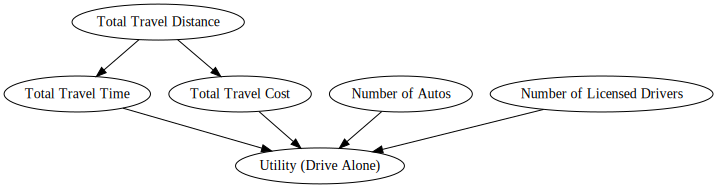

In [97]:
# Define the causal model
V_Drive_Alone = CausalGraphicalModel(nodes=["Total Travel Distance",
                                            "Total Travel Time",
                                            "Total Travel Cost",
                                            "Number of Autos",
                                            "Number of Licensed Drivers",
                                            "Utility (Drive Alone)"],
                                     edges=[("Total Travel Distance","Total Travel Time"),
                                            ("Total Travel Distance","Total Travel Cost"),
                                            ("Total Travel Time", "Utility (Drive Alone)"), 
                                            ("Total Travel Cost", "Utility (Drive Alone)"), 
                                            ("Number of Autos", "Utility (Drive Alone)"),
                                            ("Number of Licensed Drivers","Utility (Drive Alone)")
    ]
)

# draw the causal model
V_Drive_Alone.draw()

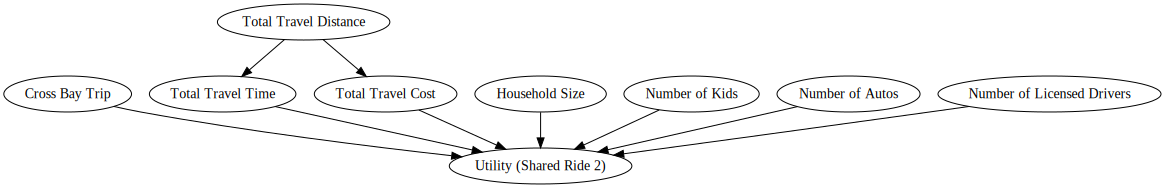

In [98]:
# Define the causal model
V_Shared_2 = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Distance",
                                         "Total Travel Cost",
                                         "Cross Bay Trip",
                                         "Number of Autos",
                                         "Number of Licensed Drivers",
                                         "Household Size",
                                         "Number of Kids",
                                         "Utility (Shared Ride 2)"],
                                  edges=[("Total Travel Distance","Total Travel Time"),
                                         ("Total Travel Distance","Total Travel Cost"),
                                         ("Total Travel Time", "Utility (Shared Ride 2)"),
                                         ("Number of Autos", "Utility (Shared Ride 2)"),
                                         ("Number of Licensed Drivers", "Utility (Shared Ride 2)"),
                                         ("Total Travel Cost", "Utility (Shared Ride 2)"),
                                         ("Household Size", "Utility (Shared Ride 2)"),
                                         ("Cross Bay Trip", "Utility (Shared Ride 2)"),
                                         ("Number of Kids", "Utility (Shared Ride 2)")
    ]
)

# draw the causal model
V_Shared_2.draw()

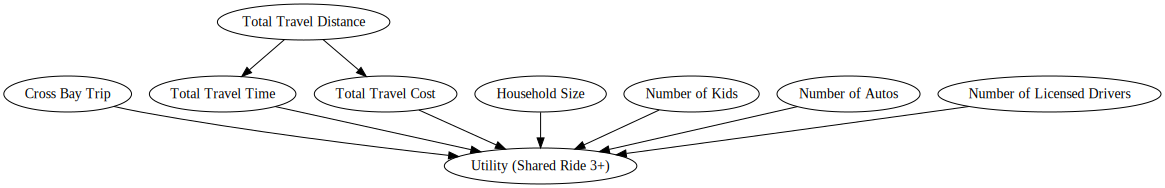

In [99]:
# Define the causal model
V_Shared_3p = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Distance",
                                         "Total Travel Cost",
                                         "Cross Bay Trip",
                                         "Number of Autos",
                                         "Number of Licensed Drivers",
                                         "Household Size",
                                         "Number of Kids",
                                         "Utility (Shared Ride 3+)"],
                                  edges=[("Total Travel Distance","Total Travel Time"),
                                         ("Total Travel Distance","Total Travel Cost"),
                                         ("Total Travel Time", "Utility (Shared Ride 3+)"),
                                         ("Number of Autos", "Utility (Shared Ride 3+)"),
                                         ("Number of Licensed Drivers", "Utility (Shared Ride 3+)"),
                                         ("Total Travel Cost", "Utility (Shared Ride 3+)"),
                                         ("Household Size", "Utility (Shared Ride 3+)"),
                                         ("Cross Bay Trip", "Utility (Shared Ride 3+)"),
                                         ("Number of Kids", "Utility (Shared Ride 3+)")
    ]
)

# draw the causal model
V_Shared_3p.draw()

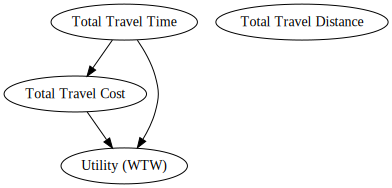

In [100]:
# Define the causal model
V_WTW = CausalGraphicalModel(nodes=["Total Travel Distance",
                                    "Total Travel Time",
                                    "Total Travel Cost",
                                    "Utility (WTW)"],
                                  edges=[("Total Travel Time", "Total Travel Cost"),
                                         ("Total Travel Time", "Utility (WTW)"),
                                         ("Total Travel Cost", "Utility (WTW)")
    ]
)

# draw the causal model
V_WTW.draw()

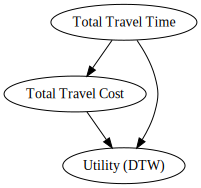

In [101]:
# Define the causal model
V_DTW = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Cost",
                                         "Utility (DTW)"],
                             edges=[("Total Travel Time", "Total Travel Cost"),
                                         ("Total Travel Time", "Utility (DTW)"),
                                         ("Total Travel Cost", "Utility (DTW)")
    ]
)

# draw the causal model
V_DTW.draw()

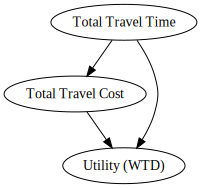

In [102]:
# Define the causal model
V_WTD = CausalGraphicalModel(nodes=["Total Travel Time",
                                    "Total Travel Cost",
                                    "Utility (WTD)"],
                             edges=[("Total Travel Time", "Total Travel Cost"),
                                    ("Total Travel Time", "Utility (WTD)"),
                                    ("Total Travel Cost", "Utility (WTD)")
    ]
)

# draw the causal model
V_WTD.draw()

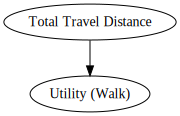

In [103]:
# Define the causal model
V_Walk = CausalGraphicalModel(nodes=["Total Travel Distance",
                                     "Utility (Walk)"],
                              edges=[("Total Travel Distance", "Utility (Walk)")
    ]
)

# draw the causal model
V_Walk.draw()

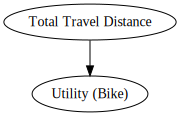

In [104]:
# Define the causal model
V_Bike = CausalGraphicalModel(nodes=["Total Travel Distance",
                                     "Utility (Bike)"],
                              edges=[("Total Travel Distance", "Utility (Bike)")
    ]
)

# draw the causal model
V_Bike.draw()

## 3.2. Distribution of Nodes without parents

### 3.2.1. Set up all needed variables

In [105]:
# Observation id column
observation_id_col = 'observation_id'

# Alternative id column
alternative_id_col = 'mode_id'

# Individual specific variables list
individual_specific_variables = ['household_size','num_kids',
                                'num_cars','num_licensed_drivers']

# Alternative specific variables dictionary
alternative_specific_dict = {1:['total_travel_distance'],
                             2:['total_travel_distance'],
                             3:['total_travel_distance'],
                             4:['total_travel_time'],
                             5:['total_travel_time'],
                             6:['total_travel_time'],
                             7:['total_travel_distance'],
                             8:['total_travel_distance']}

# Trip specific variables list
trip_specific_variables = ['cross_bay']

# Alternative name dictionary
alternative_name_dict = {1: 'drive_alone',
                         2: 'shared_2',
                         3: 'shared_3p',
                         4: 'wtw',
                         5: 'dtw',
                         6: 'wtd',
                         7: 'walk',
                         8: 'bike'}

# Variable type Dictionary
variable_type = {'num_kids': 'categorical',
                 'household_size': 'categorical',
                 'num_cars': 'categorical',
                 'num_licensed_drivers': 'categorical',
                 'cross_bay': 'categorical',
                 'total_travel_time': 'continuous',
                 'total_travel_distance': 'continuous',
                 'total_travel_cost': 'continuous'}

# Distribution to be explored for continuous variables
distributions = ['normal', 'alpha', 'beta', 'gamma', 'expon', 'gumbel']

### 3.2.2. Find Distributions of nodes without parents 

In [69]:
bike_data_params = DistNodeNoParent(data_long=bike_data_long,
                                    alt_id_col=alternative_id_col,
                                    obs_id_col=observation_id_col,
                                    alt_spec_dic=alternative_specific_dict,
                                    alt_name_dic=alternative_name_dict,
                                    ind_spec=individual_specific_variables,
                                    trip_spec=trip_specific_variables,
                                    var_types=variable_type,
                                   cont_dists=distributions)

SKIPPED normal distribution (taking more than 60 seconds)
Fitted alpha distribution with error=0.014522128648725777)


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=0.0011963782652540424)
Fitted gamma distribution with error=0.0011394543473683448)
Fitted expon distribution with error=0.002052652669300775)
SKIPPED gumbel distribution (taking more than 60 seconds)
SKIPPED normal distribution (taking more than 60 seconds)
Fitted alpha distribution with error=0.014457810916552023)
Fitted beta distribution with error=0.0012976882508515305)
Fitted gamma distribution with error=0.0012552378475140624)
Fitted expon distribution with error=0.0019967778289294194)
SKIPPED gumbel distribution (taking more than 60 seconds)
SKIPPED normal distribution (taking more than 60 seconds)
Fitted alpha distribution with error=0.014462601227138085)
Fitted beta distribution with error=0.001276124018206852)
Fitted gamma distribution with error=0.0012547975031013958)
Fitted expon distribution with error=0.0020004181046601524)
SKIPPED gumbel distribution (taking more than 60 seconds)
SKIPPED normal distribution (taking more than 60 seconds)

In [70]:
bike_data_params

{'household_size': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.        , 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
          0.12012987, 0.02997003, 0.00949051, 0.01123876])]},
 'num_kids': {'distribution': 'categorical',
  'parameters': [array([0, 1, 2, 3, 4, 5, 6]),
   array([0.46603397, 0.17682318, 0.25624376, 0.07642358, 0.01598402,
          0.00699301, 0.0014985 ])]},
 'num_cars': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.0516983 , 0.23976024, 0.48676324, 0.17057942, 0.03996004,
          0.00674326, 0.0024975 , 0.000999  , 0.000999  ])]},
 'num_licensed_drivers': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6.]),
   array([1.12387612e-02, 1.45604396e-01, 6.15134865e-01, 1.73576424e-01,
          4.47052947e-02, 9.24075924e-03, 4.99500500e-04])]},
 'total_travel_distance_drive_alone': {'distribution': 'gamma',
  'pa

In [71]:
# bike_data_params = {'household_size': {'distribution': 'categorical',
#   'parameters': [(0., 1., 2., 3., 4., 5., 6., 7., 8.),
#    (0.        , 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
#           0.12012987, 0.02997003, 0.00949051, 0.01123876)]},
#  'num_kids': {'distribution': 'categorical',
#   'parameters': [(0, 1, 2, 3, 4, 5, 6),
#    (0.46603397, 0.17682318, 0.25624376, 0.07642358, 0.01598402,
#           0.00699301, 0.0014985)]},
#  'num_cars': {'distribution': 'categorical',
#   'parameters': [(0., 1., 2., 3., 4., 5., 6., 7., 8.),
#    (0.0516983 , 0.23976024, 0.48676324, 0.17057942, 0.03996004,
#           0.00674326, 0.0024975 , 0.000999  , 0.000999  )]},
#  'num_licensed_drivers': {'distribution': 'categorical',
#   'parameters': [(0., 1., 2., 3., 4., 5., 6.),
#    (1.12387612e-02, 1.45604396e-01, 6.15134865e-01, 1.73576424e-01,
#           4.47052947e-02, 9.24075924e-03, 4.99500500e-04)]},
#  'total_travel_distance_drive_alone': {'distribution': 'halfcauchy',
#   'parameters': (0.39999999242619755, 7.6204182567397165)},
#  'total_travel_distance_shared_2': {'distribution': 'halfcauchy',
#   'parameters': (0.299999998957803, 7.584262028819065)},
#  'total_travel_distance_shared_3p': {'distribution': 'halfcauchy',
#   'parameters': (0.2999999999587918, 7.590903048398837)},
#  'total_travel_time_wtw': {'distribution': 'exponnorm',
#   'parameters': (4.461798763613399, 42.0335875728394, 14.161218106029043)},
#  'total_travel_time_dtw': {'distribution': 'fatiguelife',
#   'parameters': (0.5059992383788099, -10.97225146372076, 88.46124182265194)},
#  'total_travel_time_wtd': {'distribution': 'exponnorm',
#   'parameters': (3.4963501604509, 35.01068856093334, 14.76505046778292)},
#  'total_travel_distance_walk': {'distribution': 'halfcauchy',
#   'parameters': (0.29999999866469995, 6.616044249480995)},
#  'total_travel_distance_bike': {'distribution': 'halfcauchy',
#   'parameters': (0.3599999792235668, 5.810827941041648)},
#  'cross_bay': {'distribution': 'categorical',
#   'parameters': [np.array([0, 1]), np.array([0.94005994, 0.05994006])]}}

## 3.3. Regressions for each causal graph 

### 3.3.1. Drive Alone 

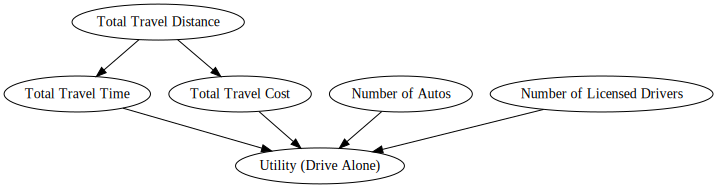

In [106]:
V_Drive_Alone.draw()

In [73]:
Drive_Alone_Df = bike_data_long[bike_data_long['mode_id']==1]
Drive_Alone_Df.reset_index(drop=True,inplace=True)
Drive_Alone_Reg = FitAlternativeRegression(regressions={1:('total_travel_distance','total_travel_cost'),
                                                        2:('total_travel_distance','total_travel_time')},
                                           reg_types={1:'linear',2:'linear'},
                                           data = Drive_Alone_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.2. Shared-2

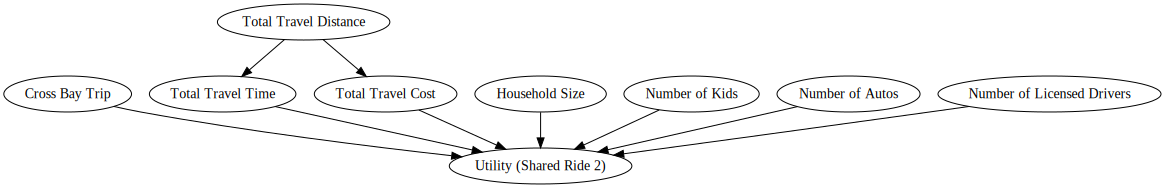

In [107]:
V_Shared_2.draw()

In [75]:
Shared_2_Df = bike_data_long[bike_data_long['mode_id']==2]
Shared_2_Df.reset_index(drop=True,inplace=True)
Shared_2_Reg = FitAlternativeRegression(regressions={1:('total_travel_distance','total_travel_cost'),
                                                        2:('total_travel_distance','total_travel_time')},
                                           reg_types={1:'linear',2:'linear'},
                                           data = Shared_2_Df)

### 3.3.3. Shared-3+

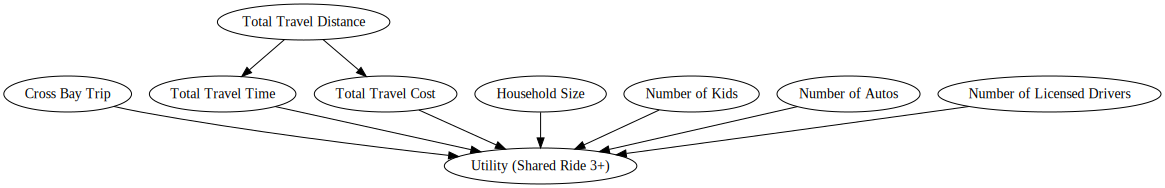

In [108]:
V_Shared_3p.draw()

In [77]:
Shared_3p_Df = bike_data_long[bike_data_long['mode_id']==3]
Shared_3p_Df.reset_index(drop=True,inplace=True)
Shared_3p_Reg = FitAlternativeRegression(regressions={1:('total_travel_distance','total_travel_cost'),
                                                        2:('total_travel_distance','total_travel_time')},
                                           reg_types={1:'linear',2:'linear'},
                                           data = Shared_3p_Df)

### 3.3.4. Walk-Transit-Walk 

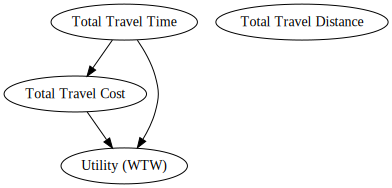

In [109]:
V_WTW.draw()

In [79]:
WTW_Df = bike_data_long[bike_data_long['mode_id']==4]
WTW_Df.reset_index(drop=True,inplace=True)
WTW_Reg = FitAlternativeRegression(regressions={1:('total_travel_time','total_travel_cost')},
                                           reg_types={1:'linear'},
                                           data = WTW_Df)

### 3.3.5. Drive-Transit-Walk 

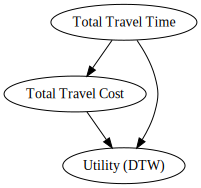

In [110]:
V_DTW.draw()

In [81]:
DTW_Df = bike_data_long[bike_data_long['mode_id']==5]
DTW_Df.reset_index(drop=True,inplace=True)
DTW_Reg = FitAlternativeRegression(regressions={1:('total_travel_time','total_travel_cost')},
                                           reg_types={1:'linear'},
                                           data = DTW_Df)

### 3.3.6. Walk-Transit-Drive 

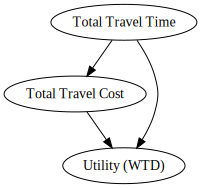

In [111]:
V_WTD.draw()

In [83]:
WTD_Df = bike_data_long[bike_data_long['mode_id']==6]
WTD_Df.reset_index(drop=True,inplace=True)
WTD_Reg = FitAlternativeRegression(regressions={1:('total_travel_time','total_travel_cost')},
                                           reg_types={1:'linear'},
                                           data = WTD_Df)

### 3.3.7. Walk

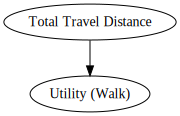

In [112]:
V_Walk.draw()

No regressions needed under the Walk alternative since the travel distance will be simulated based on the original dataset and directly affects the utility function

### 3.3.8. Bike

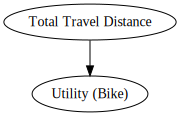

In [113]:
V_Bike.draw()

## 3.4. Simulate Nodes without Parents 

In [39]:
sim_size = 8000
sim_bike_data_no_parent = SimNodeNoParent(bike_data_params, size=sim_size)

## 3.5. Simulate data for each causal graph

In [40]:
# Create a copy of the data to avoid any issues
sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

### 3.5.1. Drive Alone 

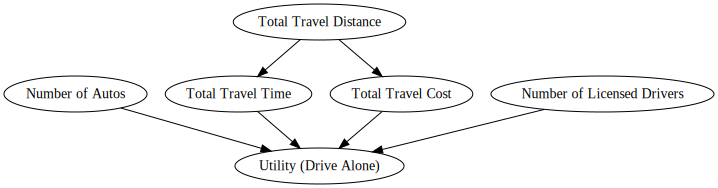

In [41]:
V_Drive_Alone.draw()

In [42]:
sim_bike_data_wide['total_travel_time_drive_alone'] = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)
sim_bike_data_wide['total_travel_cost_drive_alone'] = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)

In [43]:
# ## Loading data into StructuralCausalModel
# Drive_Alone_Model = StructuralCausalModel({
#     "total_travel_distance": lambda   n_samples: bike_data_no_parent['total_travel_distance_drive_alone'],
#     "total_travel_time": lambda total_travel_distance, n_samples: Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] + 
#                                                                   Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "total_travel_cost": lambda total_travel_distance, n_samples: Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] + 
#                                                                   Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "num_licensed_drivers": lambda n_samples: bike_data_no_parent['num_licensed_drivers'],
#     "num_cars": lambda n_samples: bike_data_no_parent['num_cars'],
#     "utility_drive_alone": lambda n_samples: np.zeros(shape=n_samples)
# })

# Drive_Alone_Model.sample(n_samples=4000).head()

### 3.5.2. Shared-2 

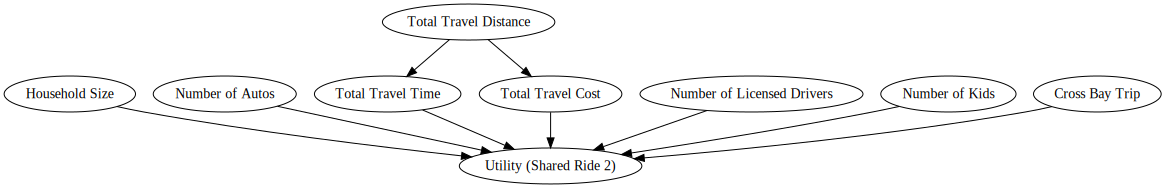

In [44]:
V_Shared_2.draw()

In [45]:
sim_bike_data_wide['total_travel_time_shared_2'] = Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                               Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)
sim_bike_data_wide['total_travel_cost_shared_2'] = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)

In [46]:
# ## Loading data into StructuralCausalModel
# Shared_2_Model = StructuralCausalModel({
#     "total_travel_distance": lambda   n_samples: bike_data_no_parent['total_travel_distance_shared_2'],
#     "total_travel_time": lambda total_travel_distance, n_samples: Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] + 
#                                                                   Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "total_travel_cost": lambda total_travel_distance, n_samples: Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] + 
#                                                                   Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "household_size": lambda n_samples: bike_data_no_parent['household_size'],
#     "num_kids": lambda n_samples: bike_data_no_parent['num_kids'],
#     "num_licensed_drivers": lambda n_samples: bike_data_no_parent['num_licensed_drivers'],
#     "num_cars": lambda n_samples: bike_data_no_parent['num_cars'],
#     "cross_bay": lambda n_samples: bike_data_no_parent['cross_bay'],
#     "utility_shared_2": total_travel_cost: lambda n_samples: np.zeros(shape=bike_data_no_parent['total_travel_distance_shared_2'].shape[0])
# })
# Shared_2_Model.sample(n_samples=4000).head()

### 3.5.3. Shared-3+

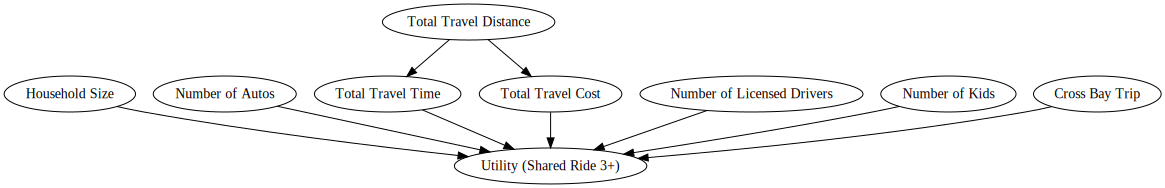

In [47]:
V_Shared_3p.draw()

In [48]:
sim_bike_data_wide['total_travel_time_shared_3p'] = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                               Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)
sim_bike_data_wide['total_travel_cost_shared_3p'] = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)

In [49]:
# ## Loading data into StructuralCausalModel
# Shared_3p_Model = StructuralCausalModel({
#     "total_travel_distance": lambda   n_samples: bike_data_no_parent['total_travel_distance_shared_3p'],
#     "total_travel_time": lambda total_travel_distance, n_samples: Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] + 
#                                                                   Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "total_travel_cost": lambda total_travel_distance, n_samples: Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] + 
#                                                                   Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "household_size": lambda n_samples: bike_data_no_parent['household_size'],
#     "num_kids": lambda n_samples: bike_data_no_parent['num_kids'],
#     "num_licensed_drivers": lambda n_samples: bike_data_no_parent['num_licensed_drivers'],
#     "num_cars": lambda n_samples: bike_data_no_parent['num_cars'],
#     "cross_bay": lambda n_samples: bike_data_no_parent['cross_bay'],
#     "utility_shared_3+": lambda n_samples: np.zeros(shape=n_samples)
# })

### 3.5.4. Walk-Transit-Walk

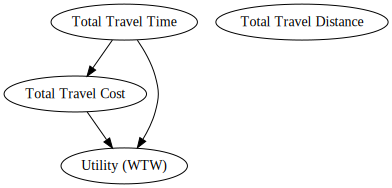

In [50]:
V_WTW.draw()

In [51]:
sim_bike_data_wide['total_travel_cost_wtw'] = WTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = sim_size)

### 3.5.5. Drive-Transit-Walk

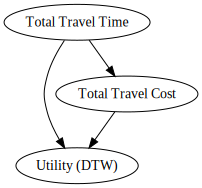

In [52]:
V_DTW.draw()

In [53]:
sim_bike_data_wide['total_travel_cost_dtw'] = DTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  DTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_dtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = DTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = sim_size)

### 3.5.6. Walk-Transit-Drive

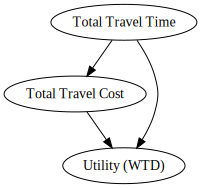

In [54]:
V_WTD.draw()

In [55]:
sim_bike_data_wide['total_travel_cost_wtd'] = WTD_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTD_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtd'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTD_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = sim_size)

### 3.5.7. Walk

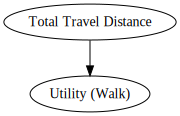

In [56]:
V_Walk.draw()

No need to simulate any other variables since Walk Total Travel Distance was already simulated

### 3.5.8. Bike

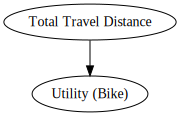

In [57]:
V_Bike.draw()

No need to simulate any other variables since Bike Total Travel Distance was already simulated

## 3.6. Simulate Availability of Alternatives 

In [58]:
# Simulate availability, add fake choice column
# and return final simulated data with availability
# and choices
wide_sim_data_availability = SimulateAvailability(data_long=bike_data_long,
                                     sim_data=sim_bike_data_wide,
                                     obs_id_col=observation_id_col,
                                     alt_name_dict=alternative_name_dict)

In [59]:
bike_data_params

{'household_size': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.        , 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
          0.12012987, 0.02997003, 0.00949051, 0.01123876])]},
 'num_kids': {'distribution': 'categorical',
  'parameters': [array([0, 1, 2, 3, 4, 5, 6]),
   array([0.46603397, 0.17682318, 0.25624376, 0.07642358, 0.01598402,
          0.00699301, 0.0014985 ])]},
 'num_cars': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.0516983 , 0.23976024, 0.48676324, 0.17057942, 0.03996004,
          0.00674326, 0.0024975 , 0.000999  , 0.000999  ])]},
 'num_licensed_drivers': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6.]),
   array([1.12387612e-02, 1.45604396e-01, 6.15134865e-01, 1.73576424e-01,
          4.47052947e-02, 9.24075924e-03, 4.99500500e-04])]},
 'total_travel_distance_drive_alone': {'distribution': 'gamma',
  'pa

In [60]:
sim_bike_data_wide.columns

Index(['household_size', 'num_kids', 'num_cars', 'num_licensed_drivers',
       'total_travel_distance_drive_alone', 'total_travel_distance_shared_2',
       'total_travel_distance_shared_3p', 'total_travel_time_wtw',
       'total_travel_time_dtw', 'total_travel_time_wtd',
       'total_travel_distance_walk', 'total_travel_distance_bike', 'cross_bay',
       'total_travel_time_drive_alone', 'total_travel_cost_drive_alone',
       'total_travel_time_shared_2', 'total_travel_cost_shared_2',
       'total_travel_time_shared_3p', 'total_travel_cost_shared_3p',
       'total_travel_cost_wtw', 'total_travel_cost_dtw',
       'total_travel_cost_wtd'],
      dtype='object')

## 3.7. Convert Simulated Data from Wide to Long

In [114]:
ind_variables = ['num_kids', 'household_size',
                 'num_cars', 'num_licensed_drivers', 'cross_bay']



# Dictionary of Alternative Specific Variables
# TODO: verify whether all variables are needed
# for each alternative
alt_varying_variables = {u'total_travel_time': dict([(1, 'total_travel_time_drive_alone'),
                                                     (2, 'total_travel_time_shared_2'),
                                                     (3, 'total_travel_time_shared_3p'),
                                                     (4, 'total_travel_time_wtw'),
                                                     (5, 'total_travel_time_dtw'),
                                                     (6, 'total_travel_time_wtd')]),
                         u'total_travel_cost': dict([(1, 'total_travel_cost_drive_alone'),
                                                     (2, 'total_travel_cost_shared_2'),
                                                     (3, 'total_travel_cost_shared_3p'),
                                                     (4, 'total_travel_cost_wtw'),
                                                     (5, 'total_travel_cost_dtw'),
                                                     (6, 'total_travel_cost_wtd')]),
                         u'total_travel_distance': dict([(1, 'total_travel_distance_drive_alone'),
                                                         (2, 'total_travel_distance_shared_2'),
                                                         (3, 'total_travel_distance_shared_3p'),
                                                         (7, 'total_travel_distance_walk'),
                                                         (8, 'total_travel_distance_bike')]),
                            }


# Dictionary of alternative availability variables
availability_variables = {1: 'drive_alone_AV',
                          2: 'shared_2_AV',
                          3: 'shared_3p_AV',
                          4: 'wtw_AV',
                          5: 'dtw_AV',
                          6: 'wtd_AV',
                          7: 'walk_AV',
                          8: 'bike_AV'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id"

# Create a custom id column that ignores the fact that this is a
# panel/repeated-observations dataset. Note the +1 ensures the id's start at one.
obs_id_column = "observation_id"
wide_sim_data_availability[obs_id_column] = np.arange(wide_sim_data_availability.shape[0],
                                         dtype=int) + 1


# Declare choice column
choice_column = "sim_choice"

In [115]:
# Convert data from wide to long
long_sim_data = pl.convert_wide_to_long(wide_sim_data_availability,
                                        ind_variables,
                                        alt_varying_variables,
                                        availability_variables,
                                        obs_id_column,
                                        choice_column,
                                        new_alt_id_name=custom_alt_id)

In [116]:
# Create a cars per licensed drivers column
long_sim_data["cars_per_licensed_drivers"] = 0
long_sim_data.loc[long_sim_data.num_licensed_drivers > 0,
                  "cars_per_licensed_drivers"] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(float)

In [117]:
# Add a variable representing cost divided by distance
long_sim_data["cost_per_distance"] = 0
long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                  "cost_per_distance"] = (long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                            "total_travel_cost"] /
                                          long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                            "total_travel_distance"])

## 3.8. Simulate Choices 

In [118]:
# Calculate probabilities for each alternative
# based on the estimated model
posterior_probs = mnl_model.predict(long_sim_data)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


In [119]:
# Simulate choice data
long_sim_data['sim_choice'] = viz.simulate_choice_vector(posterior_probs,
                               long_sim_data['observation_id'].values)

## 3.9. Estimate Model

In [120]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model_sim = pl.create_choice_model(data=long_sim_data,
                                           alt_id_col=alternative_id_col,
                                           obs_id_col=observation_id_col,
                                           choice_col=choice_column,
                                           specification=mnl_specification,
                                           model_type="MNL",
                                           names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))

# Note newton-cg used to ensure convergence to a point where gradient 
# is essentially zero for all dimensions. 
mnl_model_sim.fit_mle(np.zeros(num_vars),
                      method="BFGS")

# Look at the estimation results
mnl_model_sim.get_statsmodels_summary()

Log-likelihood at zero: -5,829.3095
Initial Log-likelihood: -5,829.3095


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.21 seconds.
Final log-likelihood: -2,191.9331


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                  sim_choice   No. Observations:                3,071
Model:             Multinomial Logit Model   Df Residuals:                    3,052
Method:                                MLE   Df Model:                           19
Date:                     Tue, 07 Apr 2020   Pseudo R-squ.:                   0.624
Time:                             17:38:41   Pseudo R-bar-squ.:               0.621
AIC:                             4,421.866   Log-Likelihood:             -2,191.933
BIC:                             4,536.432   LL-Null:                    -5,829.310
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0551      0.212     -4.970      0.000      -1.471      -0.639
ASC Shared Ride: 3+                                      3.7049      0.323     11.479      0.000       3.072       4.337
ASC Walk-Transit-Walk                                   -0.2697      0.220     -1.226      0.220      -0.701       0.161
ASC Drive-Transit-Walk                                  -2.6150      0.239    -10.923      0.000      -3.084      -2.146
ASC Walk-Transit-Drive                                  -2.9919      0.251    -11.913      0.000      -3.484      -2.500
ASC Walk                                                 1.7209      0.224      7.688      0.000       1.282       2.160
ASC Bike                                                -0.9756      0.186     -5.232      0.000      -1.341      -0.610
Travel Time, units:min (All Auto Modes)                 -0.0766      0.004    -21.119      0.000      -0.084      -0.070
Travel Time, units:min (All Transit Modes)              -0.0306      0.002    -13.134      0.000      -0.035      -0.026
Travel Cost, units:$ (All Transit Modes)                -0.1101      0.030     -3.704      0.000      -0.168      -0.052
Travel Cost per Distance, units:$/mi (Drive Alone)      -4.7503      0.285    -16.655      0.000      -5.309      -4.191
Travel Cost per Distance, units:$/mi (SharedRide-2)    -21.6654      1.071    -20.225      0.000     -23.765     -19.566
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -95.1053      4.326    -21.986      0.000    -103.584     -86.627
Autos per licensed drivers (All Auto Modes)              1.2514      0.093     13.479      0.000       1.069       1.433
Travel Distance, units:mi (Walk)                        -1.0391      0.057    -18.280      0.000      -1.151      -0.928
Travel Distance, units:mi (Bike)                        -0.3361      0.026    -12.869      0.000      -0.387      -0.285
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.7857      0.272      2.885      0.004       0.252       1.319
Household Size (Shared Ride 2 & 3+)                      0.1153      0.047      2.443      0.015       0.023       0.208
Number of Kids in Household (Shared Ride 2 & 3+)         0.7392      0.056     13.154      0.000       0.629       0.849
========================================================================================================================
"""

# 4. Estimate Causal Effects

## 4.1 Compute Initial Probabilities Using Estimated Model on Simulated Data

In [68]:
initial_probabilities = mnl_model_sim.predict(long_sim_data)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


## 4.2. Independently Generated Variables

### 4.2.1. Disturb X Independently

In [93]:
long_sim_data_naive = copy.deepcopy(long_sim_data)
long_sim_data_naive['total_travel_distance'] = 0.95 * long_sim_data_naive['total_travel_distance']

### 4.2.2. Compute Naive Probabilities Using Disturbed data and Estimated Model on Simulated Data

In [94]:
naive_probabilities = mnl_model_sim.predict(long_sim_data_naive)
long_sim_data_naive['naive_probabilities'] = naive_probabilities

## 4.3. Based on Causal Graph and Estimated Model from Simulated

In [95]:
long_sim_data_causal = copy.deepcopy(long_sim_data)

### 4.3.1. Perturb X and children nodes

In [96]:
long_sim_data_causal['total_travel_distance'] = 0.95 * long_sim_data['total_travel_distance']

### Drive Alone

In [97]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1].shape[0]

6541

In [98]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_time'] = \
                                                  (Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
                                                   Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_distance'] +\
                                                   np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1].shape[0]))

long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_cost'] = \
                                                 (Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_distance'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1].shape[0]))

### Shared-2

In [99]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_time'] = \
                                                  (Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
                                                   Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_distance'] +\
                                                   np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2].shape[0]))

long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_cost'] = \
                                                 (Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_distance'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2].shape[0]))

### Shared-3+

In [100]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_time'] = \
                                                  (Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
                                                   Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_distance'] +\
                                                   np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3].shape[0]))

long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_cost'] = \
                                                 (Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_distance'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3].shape[0]))

### Walk-Transit-Walk

In [101]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==4,'total_travel_cost'] = \
                                                 (WTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==4,'total_travel_time'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==4].shape[0]))

### Drive-Transit-Walk

In [102]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==5,'total_travel_cost'] = \
                                                 (DTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  DTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==5,'total_travel_time'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = DTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==5].shape[0]))

### Walk-Transit-Drive

In [103]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==6,'total_travel_cost'] = \
                                                 (WTD_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTD_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==6,'total_travel_time'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTD_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==6].shape[0]))

### Walk 

No further change of variables since travel distance directly affects the utility.

### Bike 

No further change of variables since travel distance directly affects the utility.

### 4.3.2. Compute Estimated Probabilities

In [104]:
estimated_probabilities = mnl_model_sim.predict(long_sim_data_causal)
long_sim_data_causal['estimated_probabilities'] = estimated_probabilities

## 4.4. Based on True Causal Graph and Original Estimated Model

In [105]:
true_probabilities = mnl_model.predict(long_sim_data_causal)
long_sim_data_causal['true_probabilities'] = true_probabilities

In [106]:
long_sim_data['initial_probabilities'] = initial_probabilities

## 4.5. Calculate Causal Effects

In [107]:
naive_effect = long_sim_data_naive.loc[long_sim_data_naive['mode_id'].isin([1, 2, 3]),'naive_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']
estimated_effect = long_sim_data_causal.loc[long_sim_data_causal['mode_id'].isin([1, 2, 3]),'estimated_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']
true_effect = long_sim_data_causal.loc[long_sim_data_causal['mode_id'].isin([1, 2, 3]),'true_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']

## 4.6. Distribution of Causal Effect by observation

Text(0.5, 1.0, 'True Effect vs. Estimated Effect')

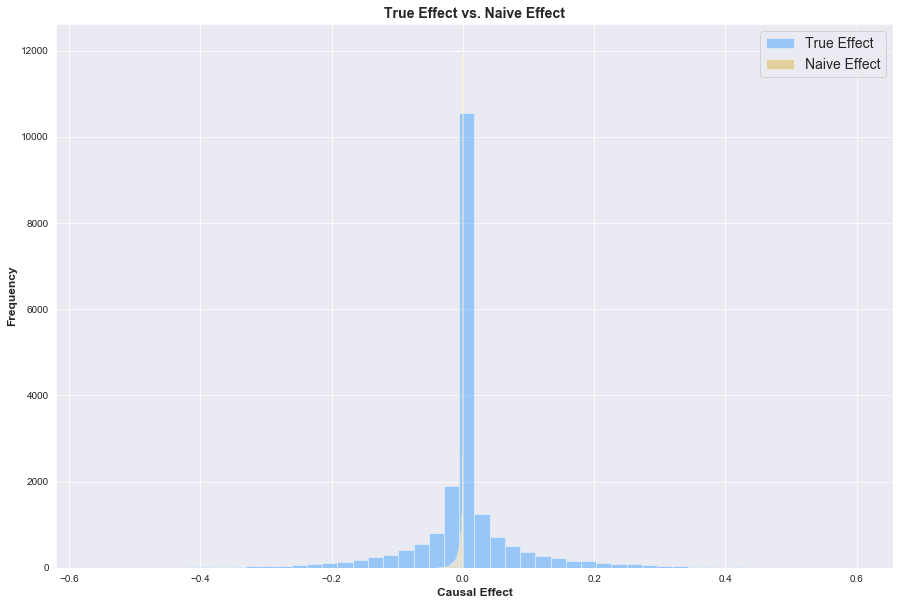

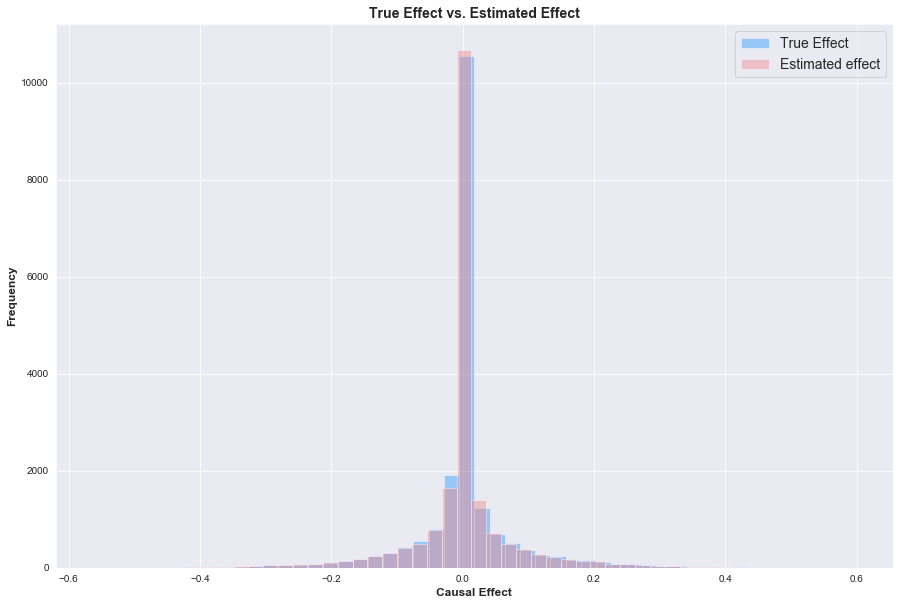

In [108]:
plt.figure(figsize=(15,10))
sns.distplot(true_effect, kde=False, label ='True Effect', color='dodgerblue')
sns.distplot(naive_effect, kde=False, label ='Naive Effect', color='goldenrod')
plt.xlabel('Causal Effect', fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.legend(prop={'size': 14})
plt.title('True Effect vs. Naive Effect', fontdict={'fontsize': 14, 'fontweight':'bold'})

plt.figure(figsize=(15,10))
sns.distplot(true_effect, kde=False, label ='True Effect', color='dodgerblue')
sns.distplot(estimated_effect, kde=False, label ='Estimated effect', color='lightcoral')
plt.xlabel('Causal Effect', fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.legend(prop={'size': 14})
plt.title('True Effect vs. Estimated Effect', fontdict={'fontsize': 14, 'fontweight':'bold'})

# 5. Repeat Simulation N times and compute Average Causal Effects

### 5.1. Run the repeated simulation

In [88]:
simulation_sizes = np.random.randint(low=3000, high=9000, size=200)
sim_number = np.arange(1,201)
models_dictionary = defaultdict(dict)
causal_effect_dictionary = {}
perturb = 0.8
simulation_data = {}

for sim_size, number in zip(simulation_sizes, sim_number):
    print('Simulation number', number , 'is in progress...')
    print ('Simulation size is', sim_size)
    print('------------------------------------------')
    print('Simulating data...')
    # Simulate data without parents
    sim_bike_data_no_parent = SimNodeNoParent(bike_data_params, size=sim_size)
    
    sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

    ############ Simulate nodes based on causal graphs ############
    ############ Drive Alone ############
    sim_bike_data_wide['total_travel_time_drive_alone'] = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size=sim_size)
    sim_bike_data_wide['total_travel_cost_drive_alone'] = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size=sim_size)
    
    # Shared Ride 2
    sim_bike_data_wide['total_travel_time_shared_2'] = Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                               Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size=sim_size)
    sim_bike_data_wide['total_travel_cost_shared_2'] = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size=sim_size)
    ############ Shared Ride 3+ ############
    sim_bike_data_wide['total_travel_time_shared_3p'] = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                                   Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                      sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                      np.random.normal(loc=0,
                                                                       scale=Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                       size=sim_size)
    sim_bike_data_wide['total_travel_cost_shared_3p'] = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                      Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                      sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                      np.random.normal(loc=0,
                                                                       scale=Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                       size=sim_size)
    ############ Walk-Transit-Walk ############
    sim_bike_data_wide['total_travel_cost_wtw'] = WTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=WTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size=sim_size)
    ############ Drive-Transit-Walk ############
    sim_bike_data_wide['total_travel_cost_dtw'] = DTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  DTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_dtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale =DTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size =sim_size)
    ############ Walk-Transit-Drive ############
    sim_bike_data_wide['total_travel_cost_wtd'] = WTD_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTD_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtd'] +\
                                                  np.random.normal(loc=0,
                                                                   scale =WTD_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size =sim_size)
    
    ############ Simulate Availability ############
    print('Simulating Availability...')
    wide_sim_data_availability = SimulateAvailability(data_long=bike_data_long,
                                         sim_data=sim_bike_data_wide,
                                         obs_id_col=observation_id_col,
                                         alt_name_dict=alternative_name_dict)

    wide_sim_data_availability[obs_id_column] = np.arange(wide_sim_data_availability.shape[0],
                                            dtype=int) + 1
    
    
    ############ Converting Data from Wide to Long ############
    print('Converting data from wide to long...')
    long_sim_data = pl.convert_wide_to_long(wide_sim_data_availability,
                                        ind_variables,
                                        alt_varying_variables,
                                        availability_variables,
                                        obs_id_column,
                                        choice_column,
                                        new_alt_id_name=custom_alt_id)
    
    # Create a cars per licensed drivers column
    long_sim_data["cars_per_licensed_drivers"] = 0
    long_sim_data.loc[long_sim_data.num_licensed_drivers > 0,
                      "cars_per_licensed_drivers"] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(float)

    # Add a variable representing cost divided by distance
    long_sim_data["cost_per_distance"] = 0
    long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                      "cost_per_distance"] = (long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                                "total_travel_cost"] /
                                              long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                        "total_travel_distance"])
    
    ############ Simulating Choices ############
    print('Simulating Choices...')
    # Calculate probabilities for each alternative
    # based on the estimated model
    posterior_probs = mnl_model.predict(long_sim_data)
    
    
    # Simulate choice data
    long_sim_data['sim_choice'] = viz.simulate_choice_vector(posterior_probs,
                               long_sim_data['observation_id'].values)
    
    
    ############ Estimating Choice Models ############
    print('Estimating the choice model...')
    # Estimate the basic MNL model, using the hessian and newton-conjugate gradient
    mnl_model_sim = pl.create_choice_model(data=long_sim_data,
                                           alt_id_col=alternative_id_col,
                                           obs_id_col=observation_id_col,
                                           choice_col=choice_column,
                                           specification=mnl_specification,
                                           model_type="MNL",
                                           names=mnl_names)

    num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))
    # Note newton-cg used to ensure convergence to a point where gradient 
    # is essentially zero for all dimensions. 
    mnl_model_sim.fit_mle(np.zeros(num_vars),
                          method="BFGS")
    
    mnl_model_sim.coefs.name = 'simulation_' + str(number)
    models_dictionary[number] = mnl_model_sim
    
    print('Estimating Causal Effects...')
    
    
    ############ Estimating Causal Effects ############
    ############ Create copies of long format data ############
    long_sim_data_naive = copy.deepcopy(long_sim_data)
    long_sim_data_causal = copy.deepcopy(long_sim_data)

    ############ Initial Probabilities ############
    initial_probabilities = mnl_model_sim.predict(long_sim_data)
    long_sim_data['initial_probabilities'] = initial_probabilities

    ############ Naive Probabilities ############
    #############################################
    long_sim_data_naive['total_travel_distance'] = perturb * long_sim_data_naive['total_travel_distance']
    naive_probabilities = mnl_model_sim.predict(long_sim_data_naive)
    long_sim_data_naive['naive_probabilities'] = naive_probabilities
    
    ############ Estimated Probabilities ############
    #################################################
    long_sim_data_causal['total_travel_distance'] = perturb * long_sim_data['total_travel_distance']
    
    ############ Perturb Variables based on Assumed Causal Graph ############
    
    ############ Drive Alone ############
    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_time'] = \
                                                  (Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
                                                   2*Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_distance'] +\
                                                   np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1].shape[0]))

    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_cost'] = \
                                                 (Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  2*Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_distance'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1].shape[0]))
    
    
    ############ Shared-2 ############
    
    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_time'] = \
                                                  (Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
                                                   2*Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_distance'] +\
                                                   np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2].shape[0]))

    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_cost'] = \
                                                 (Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  2*Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_distance'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2].shape[0]))
    
    ############ Shared 3+ ############
    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_time'] = \
                                                  (Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
                                                   2*Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_distance'] +\
                                                   np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3].shape[0]))

    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_cost'] = \
                                                 (Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  2*Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_distance'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3].shape[0]))
    
    
    ############ Walk-Transit-Walk ############
    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==4,'total_travel_cost'] = \
                                                 (WTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==4,'total_travel_time'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==4].shape[0]))
    
    
    ############ Drive-Transit-Walk ############
    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==5,'total_travel_cost'] = \
                                                 (DTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  DTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==5,'total_travel_time'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = DTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==5].shape[0]))
    
    ############ Walk-Transit-Drive ############
    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==6,'total_travel_cost'] = \
                                                 (WTD_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTD_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==6,'total_travel_time'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTD_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==6].shape[0]))
    
    
    ############ Compute Estimated Probabilities ############
    estimated_probabilities = mnl_model_sim.predict(long_sim_data_causal)
    long_sim_data_causal['estimated_probabilities'] = estimated_probabilities
    
    ############ True Probabilities ############
    true_probabilities = mnl_model.predict(long_sim_data_causal)
    long_sim_data_causal['true_probabilities'] = true_probabilities
    
    
    
#     ############ Causal Effects for Drive Alone ############
#     naive_effect = long_sim_data_naive.loc[long_sim_data_naive['mode_id'].isin([1, 2, 3]),'naive_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']
#     estimated_effect = long_sim_data_causal.loc[long_sim_data_causal['mode_id'].isin([1, 2, 3]),'estimated_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']
#     true_effect = long_sim_data_causal.loc[long_sim_data_causal['mode_id'].isin([1, 2, 3]),'true_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']
    
#     ############ DataFrame to store Causal Effects ############
#     causal_effects = causal_effects.append({'true_effect': true_effect.mean(),
#                                             'estimated_effect': estimated_effect.mean(),
#                                             'naive_effect': naive_effect.mean()}, ignore_index=True)
    
    simulation_data[number] = {}
    simulation_data[number]['long_sim_data'] = long_sim_data
    simulation_data[number]['long_sim_data_causal'] = long_sim_data_causal
    simulation_data[number]['long_sim_data_naive'] = long_sim_data_naive

    
    
    print('Simulation number', number , 'is complete!')
    print('==========================================')
    print('==========================================')

Simulation number 1 is in progress...
Simulation size is 3194
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -6,081.8286
Initial Log-likelihood: -6,081.8286
Estimation Time for Point Estimation: 0.17 seconds.
Final log-likelihood: -2,401.6126


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 1 is complete!
Simulation number 2 is in progress...
Simulation size is 7417
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,077.7399
Initial Log-likelihood: -14,077.7399


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.44 seconds.
Final log-likelihood: -5,090.6104
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 2 is complete!
Simulation number 3 is in progress...
Simulation size is 3765
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -7,133.0038
Initial Log-likelihood: -7,133.0038
Estimation Time for Point Estimation: 0.19 seconds.
Final log-likelihood: -2,630.7880


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 3 is complete!
Simulation number 4 is in progress...
Simulation size is 8197
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,547.0010
Initial Log-likelihood: -15,547.0010


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.42 seconds.
Final log-likelihood: -5,690.3301
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 4 is complete!
Simulation number 5 is in progress...
Simulation size is 8193
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,556.0016
Initial Log-likelihood: -15,556.0016


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.51 seconds.
Final log-likelihood: -5,816.5868
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 5 is complete!
Simulation number 6 is in progress...
Simulation size is 8127
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,431.5076
Initial Log-likelihood: -15,431.5076


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.47 seconds.
Final log-likelihood: -5,932.2367
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 6 is complete!
Simulation number 7 is in progress...
Simulation size is 5749
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,912.8552
Initial Log-likelihood: -10,912.8552


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.62 seconds.
Final log-likelihood: -4,089.5593
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 7 is complete!
Simulation number 8 is in progress...
Simulation size is 4118
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -7,799.1635
Initial Log-likelihood: -7,799.1635


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.48 seconds.
Final log-likelihood: -2,838.6104
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 8 is complete!
Simulation number 9 is in progress...
Simulation size is 4257
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,090.5735
Initial Log-likelihood: -8,090.5735


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -3,009.9979
Estimating Causal Effects...
Simulation number 9 is complete!
Simulation number 10 is in progress...
Simulation size is 6955
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,213.3074
Initial Log-likelihood: -13,213.3074


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.83 seconds.
Final log-likelihood: -4,862.3898
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 10 is complete!
Simulation number 11 is in progress...
Simulation size is 8621
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,395.2733
Initial Log-likelihood: -16,395.2733


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.48 seconds.
Final log-likelihood: -6,141.8254
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 11 is complete!
Simulation number 12 is in progress...
Simulation size is 6057
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,508.9389
Initial Log-likelihood: -11,508.9389


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.34 seconds.
Final log-likelihood: -4,379.2464
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 12 is complete!
Simulation number 13 is in progress...
Simulation size is 4363
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,276.9335
Initial Log-likelihood: -8,276.9335


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.21 seconds.
Final log-likelihood: -3,181.2140
Estimating Causal Effects...
Simulation number 13 is complete!
Simulation number 14 is in progress...
Simulation size is 4643
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,823.8885
Initial Log-likelihood: -8,823.8885


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.44 seconds.
Final log-likelihood: -3,385.2457
Estimating Causal Effects...
Simulation number 14 is complete!
Simulation number 15 is in progress...
Simulation size is 7352
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,950.8900
Initial Log-likelihood: -13,950.8900


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -5,291.6536
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 15 is complete!
Simulation number 16 is in progress...
Simulation size is 3521
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,672.3865
Initial Log-likelihood: -6,672.3865
Estimation Time for Point Estimation: 0.17 seconds.
Final log-likelihood: -2,532.7105


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 16 is complete!
Simulation number 17 is in progress...
Simulation size is 6738
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,766.0080
Initial Log-likelihood: -12,766.0080


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.36 seconds.
Final log-likelihood: -4,839.1134
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 17 is complete!
Simulation number 18 is in progress...
Simulation size is 7423
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,085.6173
Initial Log-likelihood: -14,085.6173


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -5,335.1072
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 18 is complete!
Simulation number 19 is in progress...
Simulation size is 8023
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,237.5473
Initial Log-likelihood: -15,237.5473


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.71 seconds.
Final log-likelihood: -5,767.1581
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 19 is complete!
Simulation number 20 is in progress...
Simulation size is 5098
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -9,685.1308
Initial Log-likelihood: -9,685.1308


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.27 seconds.
Final log-likelihood: -3,620.6158
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 20 is complete!
Simulation number 21 is in progress...
Simulation size is 6535
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,410.1517
Initial Log-likelihood: -12,410.1517


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.56 seconds.
Final log-likelihood: -4,765.9421
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 21 is complete!
Simulation number 22 is in progress...
Simulation size is 3677
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,992.6441
Initial Log-likelihood: -6,992.6441
Estimation Time for Point Estimation: 0.19 seconds.
Final log-likelihood: -2,522.8624


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 22 is complete!
Simulation number 23 is in progress...
Simulation size is 4446
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,452.4853
Initial Log-likelihood: -8,452.4853


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.25 seconds.
Final log-likelihood: -3,085.4094
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 23 is complete!
Simulation number 24 is in progress...
Simulation size is 8615
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,331.5690
Initial Log-likelihood: -16,331.5690


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.69 seconds.
Final log-likelihood: -6,107.0280
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 24 is complete!
Simulation number 25 is in progress...
Simulation size is 4687
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,855.0550
Initial Log-likelihood: -8,855.0550


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.23 seconds.
Final log-likelihood: -3,255.1232
Estimating Causal Effects...
Simulation number 25 is complete!
Simulation number 26 is in progress...
Simulation size is 4599
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,722.2425
Initial Log-likelihood: -8,722.2425


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.40 seconds.
Final log-likelihood: -3,135.0496
Estimating Causal Effects...
Simulation number 26 is complete!
Simulation number 27 is in progress...
Simulation size is 3575
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,778.5080
Initial Log-likelihood: -6,778.5080
Estimation Time for Point Estimation: 0.20 seconds.
Final log-likelihood: -2,528.7990


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 27 is complete!
Simulation number 28 is in progress...
Simulation size is 8915
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,917.4409
Initial Log-likelihood: -16,917.4409


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.51 seconds.
Final log-likelihood: -6,260.7618
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 28 is complete!
Simulation number 29 is in progress...
Simulation size is 6913
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,117.1194
Initial Log-likelihood: -13,117.1194


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.38 seconds.
Final log-likelihood: -4,738.1375
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 29 is complete!
Simulation number 30 is in progress...
Simulation size is 5642
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,692.9368
Initial Log-likelihood: -10,692.9368


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.54 seconds.
Final log-likelihood: -3,727.1926
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 30 is complete!
Simulation number 31 is in progress...
Simulation size is 6098
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,578.6922
Initial Log-likelihood: -11,578.6922


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.34 seconds.
Final log-likelihood: -4,241.1785
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 31 is complete!
Simulation number 32 is in progress...
Simulation size is 3225
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,130.8408
Initial Log-likelihood: -6,130.8408
Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -2,205.8953


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 32 is complete!
Simulation number 33 is in progress...
Simulation size is 7290
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,831.2531
Initial Log-likelihood: -13,831.2531


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -5,230.4333
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 33 is complete!
Simulation number 34 is in progress...
Simulation size is 7798
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,811.6778
Initial Log-likelihood: -14,811.6778


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.44 seconds.
Final log-likelihood: -5,527.8334
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 34 is complete!
Simulation number 35 is in progress...
Simulation size is 6394
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,122.2164
Initial Log-likelihood: -12,122.2164


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -4,654.0112
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 35 is complete!
Simulation number 36 is in progress...
Simulation size is 5799
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,027.8425
Initial Log-likelihood: -11,027.8425


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -4,238.4768
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 36 is complete!
Simulation number 37 is in progress...
Simulation size is 3567
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,774.0917
Initial Log-likelihood: -6,774.0917


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.25 seconds.
Final log-likelihood: -2,588.3737
Estimating Causal Effects...
Simulation number 37 is complete!
Simulation number 38 is in progress...
Simulation size is 8954
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,980.5943
Initial Log-likelihood: -16,980.5943


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.52 seconds.
Final log-likelihood: -6,402.0834
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 38 is complete!
Simulation number 39 is in progress...
Simulation size is 6341
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,036.6678
Initial Log-likelihood: -12,036.6678


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -4,369.9825
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 39 is complete!
Simulation number 40 is in progress...
Simulation size is 7233
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,710.8459
Initial Log-likelihood: -13,710.8459


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.41 seconds.
Final log-likelihood: -5,242.2251
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 40 is complete!
Simulation number 41 is in progress...
Simulation size is 5045
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -9,559.2609
Initial Log-likelihood: -9,559.2609


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.44 seconds.
Final log-likelihood: -3,475.9935
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 41 is complete!
Simulation number 42 is in progress...
Simulation size is 7554
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,374.8248
Initial Log-likelihood: -14,374.8248


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.53 seconds.
Final log-likelihood: -5,264.2516
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 42 is complete!
Simulation number 43 is in progress...
Simulation size is 8224
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,639.2794
Initial Log-likelihood: -15,639.2794


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.79 seconds.
Final log-likelihood: -5,651.8905
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 43 is complete!
Simulation number 44 is in progress...
Simulation size is 6789
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,882.6547
Initial Log-likelihood: -12,882.6547


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.50 seconds.
Final log-likelihood: -4,625.2143
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 44 is complete!
Simulation number 45 is in progress...
Simulation size is 7256
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,777.0856
Initial Log-likelihood: -13,777.0856


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.49 seconds.
Final log-likelihood: -5,112.8809
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 45 is complete!
Simulation number 46 is in progress...
Simulation size is 4654
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,822.2186
Initial Log-likelihood: -8,822.2186


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -3,139.4551
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 46 is complete!
Simulation number 47 is in progress...
Simulation size is 4780
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -9,052.9910
Initial Log-likelihood: -9,052.9910


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.46 seconds.
Final log-likelihood: -3,319.4627
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 47 is complete!
Simulation number 48 is in progress...
Simulation size is 4736
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -9,004.1779
Initial Log-likelihood: -9,004.1779


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.33 seconds.
Final log-likelihood: -3,401.8133
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 48 is complete!
Simulation number 49 is in progress...
Simulation size is 3185
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,027.7225
Initial Log-likelihood: -6,027.7225


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.40 seconds.
Final log-likelihood: -2,262.3406
Estimating Causal Effects...
Simulation number 49 is complete!
Simulation number 50 is in progress...
Simulation size is 4749
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,992.5186
Initial Log-likelihood: -8,992.5186


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.33 seconds.
Final log-likelihood: -3,307.9018
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 50 is complete!
Simulation number 51 is in progress...
Simulation size is 5837
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,071.2302
Initial Log-likelihood: -11,071.2302


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.33 seconds.
Final log-likelihood: -4,151.7876
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 51 is complete!
Simulation number 52 is in progress...
Simulation size is 3456
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,557.5537
Initial Log-likelihood: -6,557.5537


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -2,459.1262
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 52 is complete!
Simulation number 53 is in progress...
Simulation size is 8047
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,319.6382
Initial Log-likelihood: -15,319.6382


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.78 seconds.
Final log-likelihood: -5,658.2117
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 53 is complete!
Simulation number 54 is in progress...
Simulation size is 4353
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,241.7334
Initial Log-likelihood: -8,241.7334


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -3,107.7630
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 54 is complete!
Simulation number 55 is in progress...
Simulation size is 7831
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,861.2171
Initial Log-likelihood: -14,861.2171


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.56 seconds.
Final log-likelihood: -5,459.6673
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 55 is complete!
Simulation number 56 is in progress...
Simulation size is 4225
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,029.4927
Initial Log-likelihood: -8,029.4927


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.42 seconds.
Final log-likelihood: -2,954.4763
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 56 is complete!
Simulation number 57 is in progress...
Simulation size is 5012
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -9,552.3342
Initial Log-likelihood: -9,552.3342


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.62 seconds.
Final log-likelihood: -3,539.6245
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 57 is complete!
Simulation number 58 is in progress...
Simulation size is 7862
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,916.5700
Initial Log-likelihood: -14,916.5700


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.68 seconds.
Final log-likelihood: -5,406.2326
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 58 is complete!
Simulation number 59 is in progress...
Simulation size is 5579
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,614.4718
Initial Log-likelihood: -10,614.4718


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -3,861.6760
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 59 is complete!
Simulation number 60 is in progress...
Simulation size is 6502
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,354.2094
Initial Log-likelihood: -12,354.2094


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -4,666.9940
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 60 is complete!
Simulation number 61 is in progress...
Simulation size is 6279
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,883.0452
Initial Log-likelihood: -11,883.0452


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -4,402.8987
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 61 is complete!
Simulation number 62 is in progress...
Simulation size is 8409
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,976.5750
Initial Log-likelihood: -15,976.5750


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.41 seconds.
Final log-likelihood: -5,879.0486
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 62 is complete!
Simulation number 63 is in progress...
Simulation size is 5388
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,194.6582
Initial Log-likelihood: -10,194.6582


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -3,831.9308
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 63 is complete!
Simulation number 64 is in progress...
Simulation size is 5485
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,384.9535
Initial Log-likelihood: -10,384.9535


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -3,720.7052
Estimating Causal Effects...
Simulation number 64 is complete!
Simulation number 65 is in progress...
Simulation size is 7816
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,841.2357
Initial Log-likelihood: -14,841.2357


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.42 seconds.
Final log-likelihood: -5,566.1230
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 65 is complete!
Simulation number 66 is in progress...
Simulation size is 4280
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,130.5313
Initial Log-likelihood: -8,130.5313


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.25 seconds.
Final log-likelihood: -3,050.3687
Estimating Causal Effects...
Simulation number 66 is complete!
Simulation number 67 is in progress...
Simulation size is 4071
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -7,734.0590
Initial Log-likelihood: -7,734.0590


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -2,879.9873
Estimating Causal Effects...
Simulation number 67 is complete!
Simulation number 68 is in progress...
Simulation size is 4401
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,348.5470
Initial Log-likelihood: -8,348.5470


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -2,972.3017
Estimating Causal Effects...
Simulation number 68 is complete!
Simulation number 69 is in progress...
Simulation size is 3763
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -7,144.5912
Initial Log-likelihood: -7,144.5912
Estimation Time for Point Estimation: 0.17 seconds.
Final log-likelihood: -2,620.6653


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 69 is complete!
Simulation number 70 is in progress...
Simulation size is 8474
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,098.9015
Initial Log-likelihood: -16,098.9015


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.69 seconds.
Final log-likelihood: -5,994.4506
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 70 is complete!
Simulation number 71 is in progress...
Simulation size is 3208
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,100.3180
Initial Log-likelihood: -6,100.3180
Estimation Time for Point Estimation: 0.17 seconds.
Final log-likelihood: -2,292.4166


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 71 is complete!
Simulation number 72 is in progress...
Simulation size is 8144
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,486.1326
Initial Log-likelihood: -15,486.1326


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.58 seconds.
Final log-likelihood: -5,663.7670
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 72 is complete!
Simulation number 73 is in progress...
Simulation size is 7083
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,463.1983
Initial Log-likelihood: -13,463.1983


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.44 seconds.
Final log-likelihood: -4,923.5626
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 73 is complete!
Simulation number 74 is in progress...
Simulation size is 6349
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,026.8403
Initial Log-likelihood: -12,026.8403


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -4,502.2632
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 74 is complete!
Simulation number 75 is in progress...
Simulation size is 6286
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,894.1372
Initial Log-likelihood: -11,894.1372


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.35 seconds.
Final log-likelihood: -4,409.2966
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 75 is complete!
Simulation number 76 is in progress...
Simulation size is 4302
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,178.2562
Initial Log-likelihood: -8,178.2562


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -3,004.9355
Estimating Causal Effects...
Simulation number 76 is complete!
Simulation number 77 is in progress...
Simulation size is 6462
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,258.1339
Initial Log-likelihood: -12,258.1339


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -4,636.9748
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 77 is complete!
Simulation number 78 is in progress...
Simulation size is 8037
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,257.7097
Initial Log-likelihood: -15,257.7097


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.74 seconds.
Final log-likelihood: -5,795.3564
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 78 is complete!
Simulation number 79 is in progress...
Simulation size is 7045
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,360.3764
Initial Log-likelihood: -13,360.3764


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.40 seconds.
Final log-likelihood: -4,869.2616
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 79 is complete!
Simulation number 80 is in progress...
Simulation size is 8886
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,906.3488
Initial Log-likelihood: -16,906.3488


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.55 seconds.
Final log-likelihood: -6,267.1860
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 80 is complete!
Simulation number 81 is in progress...
Simulation size is 7612
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,468.1254
Initial Log-likelihood: -14,468.1254


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.41 seconds.
Final log-likelihood: -5,385.3019
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 81 is complete!
Simulation number 82 is in progress...
Simulation size is 5953
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,286.7845
Initial Log-likelihood: -11,286.7845


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.33 seconds.
Final log-likelihood: -4,110.7092
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 82 is complete!
Simulation number 83 is in progress...
Simulation size is 6354
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,055.5062
Initial Log-likelihood: -12,055.5062


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.78 seconds.
Final log-likelihood: -4,368.1973
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 83 is complete!
Simulation number 84 is in progress...
Simulation size is 4189
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -7,951.4615
Initial Log-likelihood: -7,951.4615


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -3,038.5471
Estimating Causal Effects...
Simulation number 84 is complete!
Simulation number 85 is in progress...
Simulation size is 5591
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,575.3137
Initial Log-likelihood: -10,575.3137


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -3,893.9208
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 85 is complete!
Simulation number 86 is in progress...
Simulation size is 8191
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,514.7690
Initial Log-likelihood: -15,514.7690


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.49 seconds.
Final log-likelihood: -5,738.3220
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 86 is complete!
Simulation number 87 is in progress...
Simulation size is 7137
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,537.7688
Initial Log-likelihood: -13,537.7688


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.38 seconds.
Final log-likelihood: -4,944.9887
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 87 is complete!
Simulation number 88 is in progress...
Simulation size is 5378
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,220.0927
Initial Log-likelihood: -10,220.0927


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.29 seconds.
Final log-likelihood: -3,780.1447
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 88 is complete!
Simulation number 89 is in progress...
Simulation size is 3110
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -5,901.8181
Initial Log-likelihood: -5,901.8181
Estimation Time for Point Estimation: 0.15 seconds.
Final log-likelihood: -2,236.6393


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 89 is complete!
Simulation number 90 is in progress...
Simulation size is 5312
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,073.5730
Initial Log-likelihood: -10,073.5730


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -3,691.1457
Estimating Causal Effects...
Simulation number 90 is complete!
Simulation number 91 is in progress...
Simulation size is 4262
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,087.8100
Initial Log-likelihood: -8,087.8100


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.25 seconds.
Final log-likelihood: -3,009.9744
Estimating Causal Effects...
Simulation number 91 is complete!
Simulation number 92 is in progress...
Simulation size is 3990
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -7,582.2542
Initial Log-likelihood: -7,582.2542


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.30 seconds.
Final log-likelihood: -2,749.9733
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 92 is complete!
Simulation number 93 is in progress...
Simulation size is 4052
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -7,691.3508
Initial Log-likelihood: -7,691.3508


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.24 seconds.
Final log-likelihood: -2,849.9580
Estimating Causal Effects...
Simulation number 93 is complete!
Simulation number 94 is in progress...
Simulation size is 7060
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,368.4549
Initial Log-likelihood: -13,368.4549


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -5,034.0470
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 94 is complete!
Simulation number 95 is in progress...
Simulation size is 4331
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,227.2631
Initial Log-likelihood: -8,227.2631


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -3,115.9187
Estimating Causal Effects...
Simulation number 95 is complete!
Simulation number 96 is in progress...
Simulation size is 8236
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,645.2090
Initial Log-likelihood: -15,645.2090


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -5,707.1312
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 96 is complete!
Simulation number 97 is in progress...
Simulation size is 8451
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,047.2492
Initial Log-likelihood: -16,047.2492


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.48 seconds.
Final log-likelihood: -6,006.6272
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 97 is complete!
Simulation number 98 is in progress...
Simulation size is 5860
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,135.9397
Initial Log-likelihood: -11,135.9397


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -4,166.3303
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 98 is complete!
Simulation number 99 is in progress...
Simulation size is 6122
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,624.6807
Initial Log-likelihood: -11,624.6807


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.45 seconds.
Final log-likelihood: -4,366.7392
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 99 is complete!
Simulation number 100 is in progress...
Simulation size is 4580
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,682.7239
Initial Log-likelihood: -8,682.7239


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.27 seconds.
Final log-likelihood: -3,093.9067
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 100 is complete!
Simulation number 101 is in progress...
Simulation size is 8220
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,616.3806
Initial Log-likelihood: -15,616.3806


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.48 seconds.
Final log-likelihood: -5,854.8460
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 101 is complete!
Simulation number 102 is in progress...
Simulation size is 5453
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,343.1845
Initial Log-likelihood: -10,343.1845


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.30 seconds.
Final log-likelihood: -3,966.2553
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 102 is complete!
Simulation number 103 is in progress...
Simulation size is 5052
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -9,602.2574
Initial Log-likelihood: -9,602.2574


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -3,626.7827
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 103 is complete!
Simulation number 104 is in progress...
Simulation size is 8675
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,421.1791
Initial Log-likelihood: -16,421.1791


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.44 seconds.
Final log-likelihood: -6,178.5436
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 104 is complete!
Simulation number 105 is in progress...
Simulation size is 3346
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,345.9315
Initial Log-likelihood: -6,345.9315
Estimation Time for Point Estimation: 0.16 seconds.
Final log-likelihood: -2,356.1067


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 105 is complete!
Simulation number 106 is in progress...
Simulation size is 7025
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,331.3140
Initial Log-likelihood: -13,331.3140


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.53 seconds.
Final log-likelihood: -5,038.9411
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 106 is complete!
Simulation number 107 is in progress...
Simulation size is 5698
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,831.1278
Initial Log-likelihood: -10,831.1278


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -4,103.3681
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 107 is complete!
Simulation number 108 is in progress...
Simulation size is 6623
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,580.4822
Initial Log-likelihood: -12,580.4822


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.72 seconds.
Final log-likelihood: -4,612.2386
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 108 is complete!
Simulation number 109 is in progress...
Simulation size is 5741
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,901.9208
Initial Log-likelihood: -10,901.9208


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.36 seconds.
Final log-likelihood: -4,080.7147
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 109 is complete!
Simulation number 110 is in progress...
Simulation size is 4528
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,592.2382
Initial Log-likelihood: -8,592.2382


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -3,203.3793
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 110 is complete!
Simulation number 111 is in progress...
Simulation size is 4721
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,960.7506
Initial Log-likelihood: -8,960.7506


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.30 seconds.
Final log-likelihood: -3,346.6608
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 111 is complete!
Simulation number 112 is in progress...
Simulation size is 4591
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,734.6220
Initial Log-likelihood: -8,734.6220


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.24 seconds.
Final log-likelihood: -3,267.2478
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 112 is complete!
Simulation number 113 is in progress...
Simulation size is 6702
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,728.6697
Initial Log-likelihood: -12,728.6697


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -4,685.6514
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 113 is complete!
Simulation number 114 is in progress...
Simulation size is 3375
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,391.8595
Initial Log-likelihood: -6,391.8595
Estimation Time for Point Estimation: 0.19 seconds.
Final log-likelihood: -2,380.4383


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 114 is complete!
Simulation number 115 is in progress...
Simulation size is 8755
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,624.5811
Initial Log-likelihood: -16,624.5811


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 1.27 seconds.
Final log-likelihood: -6,148.5384
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 115 is complete!
Simulation number 116 is in progress...
Simulation size is 7652
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,500.1000
Initial Log-likelihood: -14,500.1000


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.88 seconds.
Final log-likelihood: -5,294.2858
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 116 is complete!
Simulation number 117 is in progress...
Simulation size is 8999
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -17,119.4549
Initial Log-likelihood: -17,119.4549


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 1.21 seconds.
Final log-likelihood: -6,394.8826
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 117 is complete!
Simulation number 118 is in progress...
Simulation size is 4259
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,094.2544
Initial Log-likelihood: -8,094.2544


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.33 seconds.
Final log-likelihood: -2,921.3794
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 118 is complete!
Simulation number 119 is in progress...
Simulation size is 5618
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,671.3903
Initial Log-likelihood: -10,671.3903


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.73 seconds.
Final log-likelihood: -4,150.4387
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 119 is complete!
Simulation number 120 is in progress...
Simulation size is 5181
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -9,838.7301
Initial Log-likelihood: -9,838.7301


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -3,730.1591
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 120 is complete!
Simulation number 121 is in progress...
Simulation size is 3360
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,357.2990
Initial Log-likelihood: -6,357.2990
Estimation Time for Point Estimation: 0.19 seconds.
Final log-likelihood: -2,343.1940


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 121 is complete!
Simulation number 122 is in progress...
Simulation size is 7340
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,969.7447
Initial Log-likelihood: -13,969.7447


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.81 seconds.
Final log-likelihood: -5,375.1219
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 122 is complete!
Simulation number 123 is in progress...
Simulation size is 5817
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,014.4199
Initial Log-likelihood: -11,014.4199


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -4,176.3799
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 123 is complete!
Simulation number 124 is in progress...
Simulation size is 6367
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,098.3588
Initial Log-likelihood: -12,098.3588


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.69 seconds.
Final log-likelihood: -4,561.4234
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 124 is complete!
Simulation number 125 is in progress...
Simulation size is 3385
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,405.5441
Initial Log-likelihood: -6,405.5441
Estimation Time for Point Estimation: 0.19 seconds.
Final log-likelihood: -2,427.7337


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 125 is complete!
Simulation number 126 is in progress...
Simulation size is 7492
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,235.8376
Initial Log-likelihood: -14,235.8376


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.89 seconds.
Final log-likelihood: -5,387.8203
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 126 is complete!
Simulation number 127 is in progress...
Simulation size is 8994
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -17,054.6603
Initial Log-likelihood: -17,054.6603


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.52 seconds.
Final log-likelihood: -6,347.5929
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 127 is complete!
Simulation number 128 is in progress...
Simulation size is 8166
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,490.1636
Initial Log-likelihood: -15,490.1636


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.49 seconds.
Final log-likelihood: -5,570.1815
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 128 is complete!
Simulation number 129 is in progress...
Simulation size is 8656
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,466.3205
Initial Log-likelihood: -16,466.3205


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.49 seconds.
Final log-likelihood: -6,137.8068
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 129 is complete!
Simulation number 130 is in progress...
Simulation size is 4578
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,702.3918
Initial Log-likelihood: -8,702.3918


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -3,311.8342
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 130 is complete!
Simulation number 131 is in progress...
Simulation size is 7713
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,633.0338
Initial Log-likelihood: -14,633.0338


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -5,380.2406
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 131 is complete!
Simulation number 132 is in progress...
Simulation size is 8579
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,270.5994
Initial Log-likelihood: -16,270.5994


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.52 seconds.
Final log-likelihood: -6,122.0733
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 132 is complete!
Simulation number 133 is in progress...
Simulation size is 4285
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,150.4532
Initial Log-likelihood: -8,150.4532


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -2,946.8278
Estimating Causal Effects...
Simulation number 133 is complete!
Simulation number 134 is in progress...
Simulation size is 6978
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,243.0033
Initial Log-likelihood: -13,243.0033


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -4,719.8626
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 134 is complete!
Simulation number 135 is in progress...
Simulation size is 3640
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,914.2633
Initial Log-likelihood: -6,914.2633


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.33 seconds.
Final log-likelihood: -2,576.4209
Estimating Causal Effects...
Simulation number 135 is complete!
Simulation number 136 is in progress...
Simulation size is 8608
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,345.6636
Initial Log-likelihood: -16,345.6636


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.46 seconds.
Final log-likelihood: -6,090.4377
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 136 is complete!
Simulation number 137 is in progress...
Simulation size is 6857
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,998.3420
Initial Log-likelihood: -12,998.3420


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.45 seconds.
Final log-likelihood: -4,730.7312
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 137 is complete!
Simulation number 138 is in progress...
Simulation size is 8271
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,670.6295
Initial Log-likelihood: -15,670.6295


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.64 seconds.
Final log-likelihood: -5,889.7537
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 138 is complete!
Simulation number 139 is in progress...
Simulation size is 3001
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -5,692.9590
Initial Log-likelihood: -5,692.9590
Estimation Time for Point Estimation: 0.17 seconds.
Final log-likelihood: -2,117.9648


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 139 is complete!
Simulation number 140 is in progress...
Simulation size is 5432
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,346.5904
Initial Log-likelihood: -10,346.5904


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -3,787.4755
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 140 is complete!
Simulation number 141 is in progress...
Simulation size is 7536
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,266.4543
Initial Log-likelihood: -14,266.4543


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.45 seconds.
Final log-likelihood: -5,414.3129
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 141 is complete!
Simulation number 142 is in progress...
Simulation size is 7796
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,779.4414
Initial Log-likelihood: -14,779.4414


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.44 seconds.
Final log-likelihood: -5,422.1335
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 142 is complete!
Simulation number 143 is in progress...
Simulation size is 3317
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,302.8742
Initial Log-likelihood: -6,302.8742


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.32 seconds.
Final log-likelihood: -2,243.1025
Estimating Causal Effects...
Simulation number 143 is complete!
Simulation number 144 is in progress...
Simulation size is 8556
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,207.0267
Initial Log-likelihood: -16,207.0267


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.49 seconds.
Final log-likelihood: -6,052.5088
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 144 is complete!
Simulation number 145 is in progress...
Simulation size is 5212
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -9,888.4334
Initial Log-likelihood: -9,888.4334


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -3,529.4076
Estimating Causal Effects...
Simulation number 145 is complete!
Simulation number 146 is in progress...
Simulation size is 8132
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,451.4486
Initial Log-likelihood: -15,451.4486


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.48 seconds.
Final log-likelihood: -5,743.0264
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 146 is complete!
Simulation number 147 is in progress...
Simulation size is 5189
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -9,856.4067
Initial Log-likelihood: -9,856.4067


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -3,678.0910
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 147 is complete!
Simulation number 148 is in progress...
Simulation size is 4544
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,618.6920
Initial Log-likelihood: -8,618.6920


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -3,109.0950
Estimating Causal Effects...
Simulation number 148 is complete!
Simulation number 149 is in progress...
Simulation size is 3952
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -7,466.4006
Initial Log-likelihood: -7,466.4006


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -2,745.8953
Estimating Causal Effects...
Simulation number 149 is complete!
Simulation number 150 is in progress...
Simulation size is 5543
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,522.7214
Initial Log-likelihood: -10,522.7214


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.34 seconds.
Final log-likelihood: -3,956.7665
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 150 is complete!
Simulation number 151 is in progress...
Simulation size is 4481
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,501.9643
Initial Log-likelihood: -8,501.9643


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -3,229.2154
Estimating Causal Effects...
Simulation number 

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


151 is complete!
Simulation number 152 is in progress...
Simulation size is 5722
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,878.3347
Initial Log-likelihood: -10,878.3347


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.29 seconds.
Final log-likelihood: -4,136.1771
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 152 is complete!
Simulation number 153 is in progress...
Simulation size is 4731
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,966.9766
Initial Log-likelihood: -8,966.9766


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -3,301.6026
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 153 is complete!
Simulation number 154 is in progress...
Simulation size is 8435
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,977.7057
Initial Log-likelihood: -15,977.7057


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.72 seconds.
Final log-likelihood: -6,021.4952
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 154 is complete!
Simulation number 155 is in progress...
Simulation size is 4470
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,470.1485
Initial Log-likelihood: -8,470.1485


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -3,166.8384
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 155 is complete!
Simulation number 156 is in progress...
Simulation size is 7181
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,633.3023
Initial Log-likelihood: -13,633.3023


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.46 seconds.
Final log-likelihood: -4,974.6074
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 156 is complete!
Simulation number 157 is in progress...
Simulation size is 7232
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,728.6343
Initial Log-likelihood: -13,728.6343


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -5,290.9250
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 157 is complete!
Simulation number 158 is in progress...
Simulation size is 5737
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,916.3733
Initial Log-likelihood: -10,916.3733


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -4,141.4516
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 158 is complete!
Simulation number 159 is in progress...
Simulation size is 5482
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,407.4434
Initial Log-likelihood: -10,407.4434


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.47 seconds.
Final log-likelihood: -3,911.1172
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 159 is complete!
Simulation number 160 is in progress...
Simulation size is 8724
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,543.4174
Initial Log-likelihood: -16,543.4174


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.45 seconds.
Final log-likelihood: -6,162.6225
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 160 is complete!
Simulation number 161 is in progress...
Simulation size is 8839
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,811.1540
Initial Log-likelihood: -16,811.1540


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -6,344.1228
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 161 is complete!
Simulation number 162 is in progress...
Simulation size is 7124
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,556.2293
Initial Log-likelihood: -13,556.2293


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -5,159.0332
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 162 is complete!
Simulation number 163 is in progress...
Simulation size is 8129
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,412.1586
Initial Log-likelihood: -15,412.1586


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.45 seconds.
Final log-likelihood: -5,753.3643
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 163 is complete!
Simulation number 164 is in progress...
Simulation size is 3016
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -5,733.0855
Initial Log-likelihood: -5,733.0855


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -2,123.5565
Estimating Causal Effects...
Simulation number 164 is complete!
Simulation number 165 is in progress...
Simulation size is 5533
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -10,484.6347
Initial Log-likelihood: -10,484.6347


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -3,894.5992
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 165 is complete!
Simulation number 166 is in progress...
Simulation size is 7240
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -13,763.0101
Initial Log-likelihood: -13,763.0101


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -4,962.3338
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 166 is complete!
Simulation number 167 is in progress...
Simulation size is 8710
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,498.1088
Initial Log-likelihood: -16,498.1088


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.86 seconds.
Final log-likelihood: -6,057.3985
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 167 is complete!
Simulation number 168 is in progress...
Simulation size is 4755
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -9,012.0795
Initial Log-likelihood: -9,012.0795


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.36 seconds.
Final log-likelihood: -3,350.1790
Estimating Causal Effects...
Simulation number 168 is complete!
Simulation number 169 is in progress...
Simulation size is 6841
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,981.8904
Initial Log-likelihood: -12,981.8904


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.36 seconds.
Final log-likelihood: -4,741.2005
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 169 is complete!
Simulation number 170 is in progress...
Simulation size is 8738
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,569.1480
Initial Log-likelihood: -16,569.1480


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.47 seconds.
Final log-likelihood: -6,234.2595
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 170 is complete!
Simulation number 171 is in progress...
Simulation size is 7507
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,230.1755
Initial Log-likelihood: -14,230.1755


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.57 seconds.
Final log-likelihood: -5,237.5942
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 171 is complete!
Simulation number 172 is in progress...
Simulation size is 7515
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,296.4197
Initial Log-likelihood: -14,296.4197


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.68 seconds.
Final log-likelihood: -5,382.5318
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 172 is complete!
Simulation number 173 is in progress...
Simulation size is 6472
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,303.5664
Initial Log-likelihood: -12,303.5664


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.36 seconds.
Final log-likelihood: -4,595.3800
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 173 is complete!
Simulation number 174 is in progress...
Simulation size is 6535
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,393.2409
Initial Log-likelihood: -12,393.2409


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.46 seconds.
Final log-likelihood: -4,612.2815
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 174 is complete!
Simulation number 175 is in progress...
Simulation size is 4769
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -9,055.9739
Initial Log-likelihood: -9,055.9739


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.24 seconds.
Final log-likelihood: -3,504.2594
Estimating Causal Effects...
Simulation number 175 is complete!
Simulation number 176 is in progress...
Simulation size is 3895

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -7,389.2250
Initial Log-likelihood: -7,389.2250


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -2,805.4629
Estimating Causal Effects...
Simulation number 176 is complete!
Simulation number 177 is in progress...
Simulation size is 8523
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,152.9663
Initial Log-likelihood: -16,152.9663


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.66 seconds.
Final log-likelihood: -5,957.0528
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 177 is complete!
Simulation number 178 is in progress...
Simulation size is 4710
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,935.5426
Initial Log-likelihood: -8,935.5426
Estimation Time for Point Estimation: 0.20 seconds.
Final log-likelihood: -3,292.5720


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 178 is complete!
Simulation number 179 is in progress...
Simulation size is 8460
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,054.9321
Initial Log-likelihood: -16,054.9321


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -5,934.1415
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 179 is complete!
Simulation number 180 is in progress...
Simulation size is 6222
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,807.3097
Initial Log-likelihood: -11,807.3097


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.34 seconds.
Final log-likelihood: -4,286.7489
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 180 is complete!
Simulation number 181 is in progress...
Simulation size is 8546
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,253.9126
Initial Log-likelihood: -16,253.9126


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.47 seconds.
Final log-likelihood: -5,918.7246
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 181 is complete!
Simulation number 182 is in progress...
Simulation size is 6329
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,997.8801
Initial Log-likelihood: -11,997.8801


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.36 seconds.
Final log-likelihood: -4,504.9980
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 182 is complete!
Simulation number 183 is in progress...
Simulation size is 4529
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,596.5375
Initial Log-likelihood: -8,596.5375


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -3,137.6130
Estimating Causal Effects...
Simulation number 183 is complete!
Simulation number 184 is in progress...
Simulation size is 8919
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,918.4801
Initial Log-likelihood: -16,918.4801


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.47 seconds.
Final log-likelihood: -6,196.5440
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 184 is complete!
Simulation number 185 is in progress...
Simulation size is 4420
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,384.3171
Initial Log-likelihood: -8,384.3171


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.21 seconds.
Final log-likelihood: -3,197.5420
Estimating Causal Effects...
Simulation number 185 is complete!
Simulation number 186 is in progress...
Simulation size is 5126
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -9,738.6933
Initial Log-likelihood: -9,738.6933


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.23 seconds.
Final log-likelihood: -3,656.2735
Estimating Causal Effects...
Simulation number 186

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


 is complete!
Simulation number 187 is in progress...
Simulation size is 3237
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -6,143.8444
Initial Log-likelihood: -6,143.8444
Estimation Time for Point Estimation: 0.16 seconds.
Final log-likelihood: -2,324.0248


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 187 is complete!
Simulation number 188 is in progress...
Simulation size is 4084
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -7,747.7959
Initial Log-likelihood: -7,747.7959


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.21 seconds.
Final log-likelihood: -2,880.3539
Estimating Causal Effects...
Simulation number 188 is complete!
Simulation number 189 is in progress...
Simulation size is 6110
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,591.8188
Initial Log-likelihood: -11,591.8188


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.34 seconds.
Final log-likelihood: -4,348.7466
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 189 is complete!
Simulation number 190 is in progress...
Simulation size is 7548
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,325.3309
Initial Log-likelihood: -14,325.3309


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.69 seconds.
Final log-likelihood: -5,289.1326
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 190 is complete!
Simulation number 191 is in progress...
Simulation size is 3816
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -7,237.4851
Initial Log-likelihood: -7,237.4851
Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -2,698.1842


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 191 is complete!
Simulation number 192 is in progress...
Simulation size is 4360
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -8,276.7116
Initial Log-likelihood: -8,276.7116


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -3,083.6648
Estimating Causal Effects...
Simulation number 192 is complete!
Simulation number 193 is in progress...
Simulation size is 8407
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -15,950.3630
Initial Log-likelihood: -15,950.3630


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -5,951.8541
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 193 is complete!
Simulation number 194 is in progress...
Simulation size is 3907
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -7,421.7731
Initial Log-likelihood: -7,421.7731


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -2,791.7844
Estimating Causal Effects...
Simulation number 194 is complete!
Simulation number 195 is in progress...
Simulation size is 7611
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,464.2622
Initial Log-likelihood: -14,464.2622


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.42 seconds.
Final log-likelihood: -5,425.3887
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 195 is complete!
Simulation number 196 is in progress...
Simulation size is 7488
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -14,204.4965
Initial Log-likelihood: -14,204.4965


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.38 seconds.
Final log-likelihood: -5,236.0304
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 196 is complete!
Simulation number 197 is in progress...
Simulation size is 8780
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -16,676.7855
Initial Log-likelihood: -16,676.7855


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.52 seconds.
Final log-likelihood: -6,171.2037
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 197 is complete!
Simulation number 198 is in progress...
Simulation size is 6027
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -11,419.1872
Initial Log-likelihood: -11,419.1872


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.57 seconds.
Final log-likelihood: -4,230.6181
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 198 is complete!
Simulation number 199 is in progress...
Simulation size is 6574
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -12,513.3847
Initial Log-likelihood: -12,513.3847


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.32 seconds.
Final log-likelihood: -4,582.1413
Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 199 is complete!
Simulation number 200 is in progress...
Simulation size is 3071
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...
Log-likelihood at zero: -5,829.3095
Initial Log-likelihood: -5,829.3095
Estimation Time for Point Estimation: 0.15 seconds.
Final log-likelihood: -2,277.0627


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 200 is complete!


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


In [95]:
causal_effects = pd.DataFrame(columns=['naive_effect','true_effect','estimated_effect'])
for number in sim_number:
    initial_data=simulation_data[number]['long_sim_data']
    naive_data=simulation_data[number]['long_sim_data_naive']
    causal_data=simulation_data[number]['long_sim_data_causal']

    naive_effect = naive_data.loc[naive_data['mode_id'].isin([1,2,3]),'naive_probabilities'] - initial_data.loc[initial_data['mode_id'].isin([1,2,3]),'initial_probabilities']
    estimated_effect = causal_data.loc[causal_data['mode_id'].isin([1,2,3]),'estimated_probabilities'] - initial_data.loc[initial_data['mode_id'].isin([1,2,3]),'initial_probabilities']
    true_effect = causal_data.loc[causal_data['mode_id'].isin([1,2,3]),'true_probabilities'] - initial_data.loc[initial_data['mode_id'].isin([1,2,3]),'initial_probabilities']

    causal_effects = causal_effects.append({'true_effect': true_effect.mean(),
                                            'estimated_effect': estimated_effect.mean(),
                                            'naive_effect': naive_effect.mean()}, ignore_index=True)
    
    

### 5.2. Describe resulting DataFrame

# 5. Plotting results of the simulation 

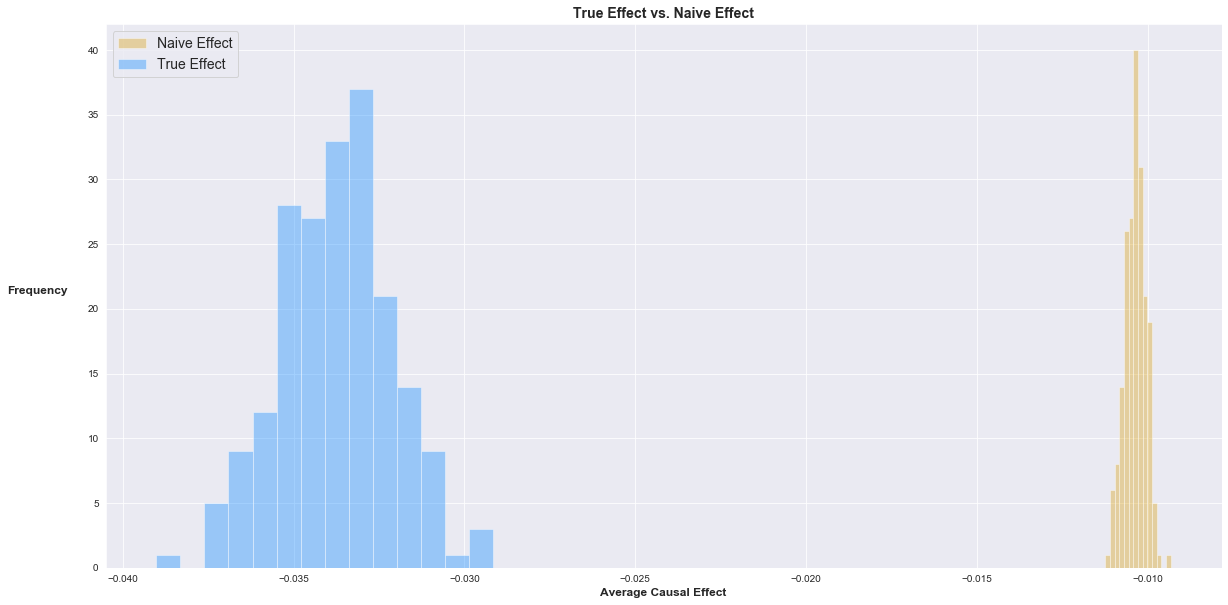

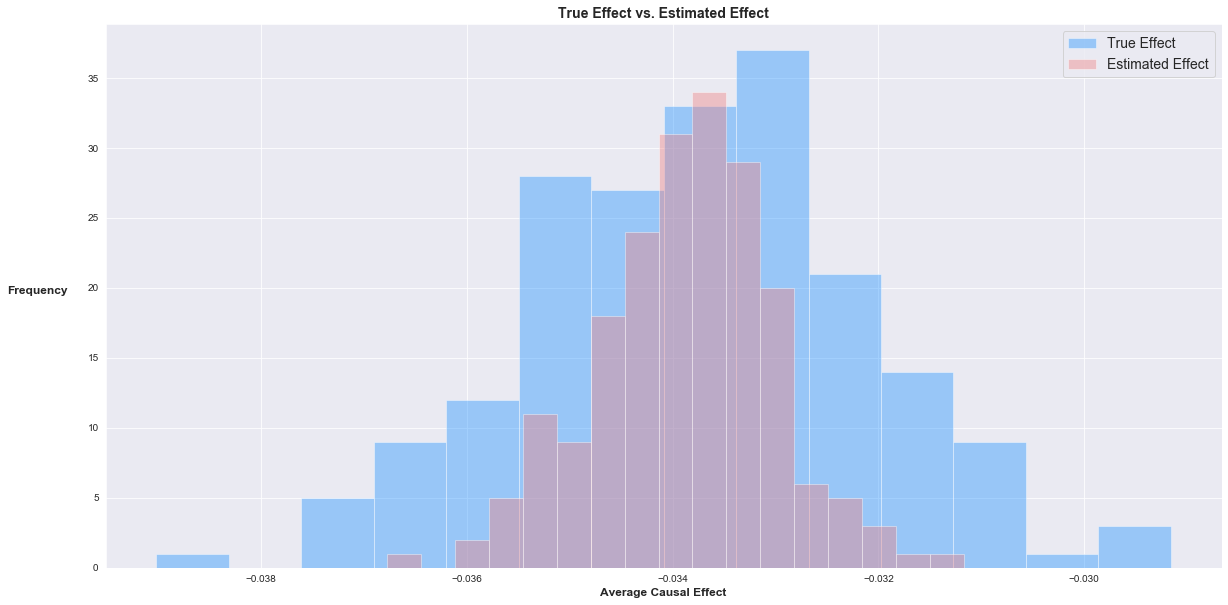

In [96]:
plt.figure(figsize=(20,10))
sns.distplot(causal_effects.naive_effect, label='Naive Effect', kde=False, color='goldenrod')
sns.distplot(causal_effects.true_effect, label='True Effect', kde=False, color='dodgerblue')
plt.title('True Effect vs. Naive Effect', fontdict={'fontsize': 14, 'fontweight':'bold'})
plt.ylabel('Frequency', rotation=0, labelpad=50, fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.xlabel('Average Causal Effect', fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.legend(prop={'size': 14})

plt.figure(figsize=(20,10))
sns.distplot(causal_effects.true_effect, label='True Effect',kde=False, color='dodgerblue')
sns.distplot(causal_effects.estimated_effect, label='Estimated Effect', kde=False,color='lightcoral')
plt.title('True Effect vs. Estimated Effect', fontdict={'fontsize': 14, 'fontweight':'bold'})
plt.ylabel('Frequency', rotation=0, labelpad=50, fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.xlabel('Average Causal Effect', fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.legend(prop={'size': 14})

In [ ]:
mnl_model.po